#4-7. LightGBM

- 부스팅 개열 알고리즘
- 장점 - XGBoost보다 더 빠른 학습과 예측 수행 시간, 더 작은 메모리 사용량, 카테고리형 피처의 자동 변환과 최적 분할
- 단점 - 적은 데이터 세트(10,000건 이하)에 적용할 경우 과적합 발생
- 리프 중심 트리 분할(Leaf Wise): 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할
  - 반대 개념) 균형 트리 분할(Level Wise): 트리의 깊이를 효과적으로 줄이기 위함

In [ ]:
import lightgbm

print(lightgbm.__version__)

4.1.0


- 주요 파라미터
  - n_estimators [default=100]: 반복 수행하려는 트리의 개수. 너무 크면 과적합
  - learning_rate [default=0.1]: 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
  - **max_depth** [default=-1]: 균형 트리 분할보다 상대적으로 더 깊음
  - **min_child_samples** [default=20]: min_samples_leaf와 같은 개념. 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수
  - **num_leaves** [default=31]: 하나의 트리가 가질 수 있는 최대 리프 개수
  - boosting [default=gbdt]: 부스팅 알고리즘. rf(랜덤포레스트) 지정 가능
  - subsample [default=1.0]: 데이터 샘플링 비율
  - colsample_bytree [default=1.0]: 개별 트리 학습 시 무작위로 선택하는 피처의 비율
  - reg_lambda [default=0.0]: L2 regulation 제어 값. 클수록 과적합 방지
  - reg_alpha [default=0.0]: L1 regulation 제어 값
  - objective: 손실함수 지정

LightGBM 적용 - 위스콘신 유방암 예측

In [94]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier
import lightgbm as lgbm

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능 - (버전 4.0.0 이상에서는 fit에서 early_stopping_rounds, verbose 작동 X)
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, callbacks=[lgbm.early_stopping(stopping_rounds=50)], eval_metric="logloss", eval_set=evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


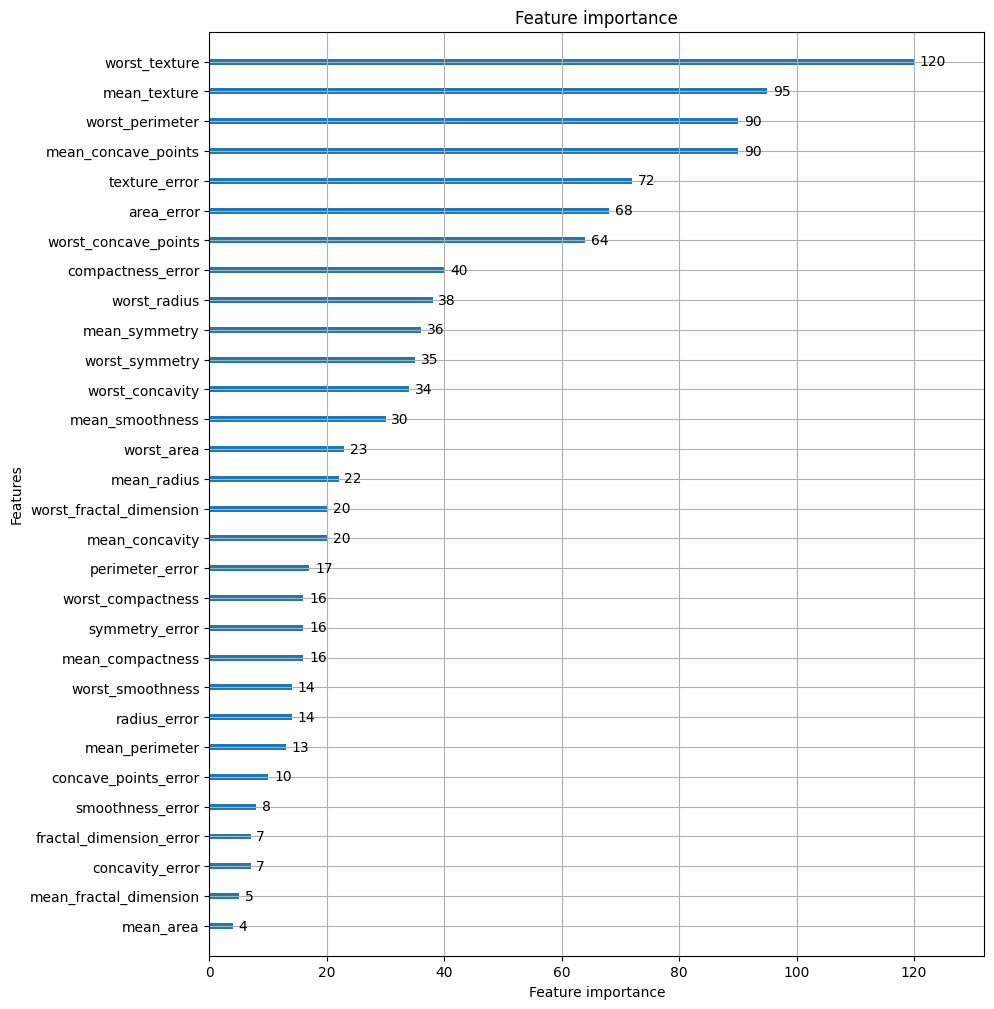

In [ ]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

#4-8. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

- Grid Search의 단점 - 하이퍼 파라미터 값의 범위가 넓거나 학습 데이터가 대용량일 경우 수행 시간이 매우 오래 걸림
- 베이지안 최적화: 목적 함수 식을 제대로 알 수 없는 상태에서 최대 또는 최소 함수 반환 값을 만드는 쵲거 입력값을 찾아주는 방식
  - 대체 모델(Surrogate Model): 최적 함수를 예측할 수 있는 입력값을 추천받은 뒤 최적 함수 모델 개선
  - 획득 함수(Acquisition Function): 개선된 대체 모델을 기반으로 최적 입력값 계산

In [ ]:
import hyperopt

print(hyperopt.__version__)

0.2.7


### HyperOpt 사용하기
- 로직: 입력 변수명과 입력값의 검색 공간(Search Space) 설정 -> 목적 함수 설정 -> 목적 함수의 반환 최솟값을 가지는 최적 입력값 유추

검색 공간 설정

In [ ]:
from hyperopt import hp

# hp.quniform('x', -10, 10, 1): -10부터 10까지 1 간격을 가지는 값들
# x, y 입력 변수 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

목적 함수 설정

In [ ]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

# x는 -10~10, y는 -15~15 -> x는 0에 가까울수록, y는 15에 가까울수록 목적 함수 출력값 최소

최적의 입력값을 베이지안 최적화 기법에 기반하여 유추
- fmin(objective, space, algo, max_evals, trials)
  - fn: 목적 함수
  - space: 검색 공간 딕셔너리
  - algo: 베이지안 최적화 적용 알고리즘
  - max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수
  - trials: 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과
  - rstate: random_state 개념

In [ ]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 522.89trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [ ]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 668.65trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


Trials 객체
- results: 반환값
  - {'loss': 함수 반환값, 'status': 반환 상태값}
- vals: 입력 변숫값
  - {'입력변수명': 개별 수행 시마다 입력된 값 리스트}

In [ ]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [ ]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


Trials 객체를 DataFrame으로 변환

In [ ]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성.
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

HyperOpt로 하이퍼 파라미터 튜닝 시 주의점
- 형변환 필요 (하이퍼 파라미터 - 정수, HyperOpt - 실수)
- 성능 값이 클수록 좋은 지표일 경우 -1을 곱해줘야 함

In [ ]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다.
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [ ]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:22<00:00,  2.19trial/s, best loss: -0.967047170907401]
best: {'colsample_bytree': 0.548301545497125, 'learning_rate': 0.1840281762576621, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.5483, learning_rate:0.18403, max_depth:18, min_child_weight:2


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.52464	validation_1-logloss:0.55510
[1]	validation_0-logloss:0.42441	validation_1-logloss:0.48641
[2]	validation_0-logloss:0.35023	validation_1-logloss:0.43336
[3]	validation_0-logloss:0.29341	validation_1-logloss:0.39157
[4]	validation_0-logloss:0.24995	validation_1-logloss:0.35869
[5]	validation_0-logloss:0.21406	validation_1-logloss:0.33711
[6]	validation_0-logloss:0.18467	validation_1-logloss:0.32415
[7]	validation_0-logloss:0.16291	validation_1-logloss:0.30830
[8]	validation_0-logloss:0.14352	validation_1-logloss:0.29894
[9]	validation_0-logloss:0.12620	validation_1-logloss:0.27850
[10]	validation_0-logloss:0.11240	validation_1-logloss:0.27026
[11]	validation_0-logloss:0.10142	validation_1-logloss:0.26501
[12]	validation_0-logloss:0.09186	validation_1-logloss:0.26248
[13]	validation_0-logloss:0.08452	validation_1-logloss:0.25936
[14]	validation_0-logloss:0.07803	validation_1-logloss:0.26213
[15]	validation_0-logloss:0.07128	validation_1-logloss:0.25470
[1

#4-9. 분류실습 - 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("/content/drive/MyDrive/CUAI/파이썬 머신러닝 완벽 가이드/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
cust_df['var3'].value_counts()
# -999999값이 116개 존재

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: count, Length: 208, dtype: int64

In [ ]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)
# 학습과 테스트 데이터 세트 모두 TARGET값 분포가 원본 데이터와 유사한 비율로 나타남

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

튜닝 X

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

튜닝 O

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색.

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정.
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[68]	validation_0-auc:0.89247	validation_1-auc:0.83282                                                                 
[69]	validation_0-auc:0.89266	validation_1-auc:0.83292                                                                 
[70]	validation_0-auc:0.89306	validation_1-auc:0.83292                                                                 
[71]	validation_0-auc:0.89358	validation_1-auc:0.83264                                                                 
[72]	validation_0-auc:0.89402	validation_1-auc:0.83256                                                                 
[73]	validation_0-auc:0.89428	validation_1-auc:0.83239                                                                 
[74]	validation_0-auc:0.89455	validation_1-auc:0.83261                                                                 
[75]	validation_0-auc:0.89482	validation_1-auc:0.83233                                                                 
[76]	validation_0-auc:0.89494	validation

[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88500	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88618	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88687	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88845	validation_1-auc:0.83647                                                                 
[55]	validation_0-auc:0.88910	validation

[15]	validation_0-auc:0.85543	validation_1-auc:0.82596                                                                 
[16]	validation_0-auc:0.85660	validation_1-auc:0.82658                                                                 
[17]	validation_0-auc:0.85740	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.85886	validation_1-auc:0.82679                                                                 
[19]	validation_0-auc:0.85976	validation_1-auc:0.82722                                                                 
[20]	validation_0-auc:0.86042	validation_1-auc:0.82733                                                                 
[21]	validation_0-auc:0.86157	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.86180	validation_1-auc:0.82913                                                                 
[23]	validation_0-auc:0.86289	validation

[83]	validation_0-auc:0.90075	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90107	validation_1-auc:0.83727                                                                 
[85]	validation_0-auc:0.90143	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90158	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90167	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90173	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90208	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90247	validation_1-auc:0.83791                                                                 
[91]	validation_0-auc:0.90255	validation

[51]	validation_0-auc:0.90402	validation_1-auc:0.83032                                                                 
[52]	validation_0-auc:0.90437	validation_1-auc:0.83093                                                                 
[53]	validation_0-auc:0.90514	validation_1-auc:0.82994                                                                 
[54]	validation_0-auc:0.90563	validation_1-auc:0.82977                                                                 
[55]	validation_0-auc:0.90637	validation_1-auc:0.82996                                                                 
[56]	validation_0-auc:0.90670	validation_1-auc:0.82932                                                                 
[57]	validation_0-auc:0.90707	validation_1-auc:0.82900                                                                 
[58]	validation_0-auc:0.90802	validation_1-auc:0.82926                                                                 
[59]	validation_0-auc:0.90872	validation

[37]	validation_0-auc:0.89056	validation_1-auc:0.82864                                                                 
[38]	validation_0-auc:0.89098	validation_1-auc:0.82831                                                                 
[39]	validation_0-auc:0.89169	validation_1-auc:0.82861                                                                 
[40]	validation_0-auc:0.89308	validation_1-auc:0.82975                                                                 
[41]	validation_0-auc:0.89324	validation_1-auc:0.82911                                                                 
[42]	validation_0-auc:0.89554	validation_1-auc:0.82967                                                                 
[43]	validation_0-auc:0.89671	validation_1-auc:0.82997                                                                 
[44]	validation_0-auc:0.89801	validation_1-auc:0.83066                                                                 
[45]	validation_0-auc:0.89858	validation

[5]	validation_0-auc:0.85511	validation_1-auc:0.82100                                                                  
[6]	validation_0-auc:0.85611	validation_1-auc:0.82251                                                                  
[7]	validation_0-auc:0.85814	validation_1-auc:0.82231                                                                  
[8]	validation_0-auc:0.85953	validation_1-auc:0.82212                                                                  
[9]	validation_0-auc:0.86282	validation_1-auc:0.82205                                                                  
[10]	validation_0-auc:0.86284	validation_1-auc:0.82076                                                                 
[11]	validation_0-auc:0.86207	validation_1-auc:0.82028                                                                 
[12]	validation_0-auc:0.86463	validation_1-auc:0.82218                                                                 
[13]	validation_0-auc:0.86692	validation

[73]	validation_0-auc:0.91874	validation_1-auc:0.83085                                                                 
[74]	validation_0-auc:0.91944	validation_1-auc:0.83065                                                                 
[75]	validation_0-auc:0.91976	validation_1-auc:0.83107                                                                 
[76]	validation_0-auc:0.92022	validation_1-auc:0.83147                                                                 
[77]	validation_0-auc:0.92049	validation_1-auc:0.83143                                                                 
[78]	validation_0-auc:0.92081	validation_1-auc:0.83193                                                                 
[79]	validation_0-auc:0.92117	validation_1-auc:0.83232                                                                 
[80]	validation_0-auc:0.92192	validation_1-auc:0.83284                                                                 
[81]	validation_0-auc:0.92240	validation

[41]	validation_0-auc:0.93513	validation_1-auc:0.82577                                                                 
[42]	validation_0-auc:0.93574	validation_1-auc:0.82560                                                                 
[43]	validation_0-auc:0.93603	validation_1-auc:0.82574                                                                 
[44]	validation_0-auc:0.93697	validation_1-auc:0.82628                                                                 
[45]	validation_0-auc:0.93714	validation_1-auc:0.82631                                                                 
[46]	validation_0-auc:0.93738	validation_1-auc:0.82635                                                                 
[47]	validation_0-auc:0.93798	validation_1-auc:0.82599                                                                 
[48]	validation_0-auc:0.93835	validation_1-auc:0.82550                                                                 
[49]	validation_0-auc:0.93861	validation

[51]	validation_0-auc:0.94151	validation_1-auc:0.83151                                                                 
[52]	validation_0-auc:0.94212	validation_1-auc:0.83151                                                                 
[53]	validation_0-auc:0.94252	validation_1-auc:0.83139                                                                 
[54]	validation_0-auc:0.94318	validation_1-auc:0.83146                                                                 
[0]	validation_0-auc:0.83493	validation_1-auc:0.81063                                                                  
[1]	validation_0-auc:0.84197	validation_1-auc:0.81316                                                                  
[2]	validation_0-auc:0.85026	validation_1-auc:0.81739                                                                  
[3]	validation_0-auc:0.85484	validation_1-auc:0.81605                                                                  
[4]	validation_0-auc:0.85947	validation_

[64]	validation_0-auc:0.94598	validation_1-auc:0.83213                                                                 
[65]	validation_0-auc:0.94626	validation_1-auc:0.83215                                                                 
[66]	validation_0-auc:0.94647	validation_1-auc:0.83167                                                                 
[67]	validation_0-auc:0.94659	validation_1-auc:0.83147                                                                 
[68]	validation_0-auc:0.94664	validation_1-auc:0.83137                                                                 
[69]	validation_0-auc:0.94672	validation_1-auc:0.83122                                                                 
[70]	validation_0-auc:0.94741	validation_1-auc:0.83109                                                                 
[71]	validation_0-auc:0.94752	validation_1-auc:0.83093                                                                 
[72]	validation_0-auc:0.94770	validation

[45]	validation_0-auc:0.89463	validation_1-auc:0.83043                                                                 
[46]	validation_0-auc:0.89489	validation_1-auc:0.83080                                                                 
[47]	validation_0-auc:0.89599	validation_1-auc:0.83056                                                                 
[48]	validation_0-auc:0.89665	validation_1-auc:0.83082                                                                 
[49]	validation_0-auc:0.89744	validation_1-auc:0.83093                                                                 
[50]	validation_0-auc:0.89782	validation_1-auc:0.83066                                                                 
[51]	validation_0-auc:0.89842	validation_1-auc:0.83060                                                                 
[52]	validation_0-auc:0.89949	validation_1-auc:0.83067                                                                 
[53]	validation_0-auc:0.90008	validation

[13]	validation_0-auc:0.86039	validation_1-auc:0.82427                                                                 
[14]	validation_0-auc:0.86126	validation_1-auc:0.82481                                                                 
[15]	validation_0-auc:0.86335	validation_1-auc:0.82649                                                                 
[16]	validation_0-auc:0.86505	validation_1-auc:0.82707                                                                 
[17]	validation_0-auc:0.86622	validation_1-auc:0.82740                                                                 
[18]	validation_0-auc:0.86591	validation_1-auc:0.82552                                                                 
[19]	validation_0-auc:0.86830	validation_1-auc:0.82661                                                                 
[20]	validation_0-auc:0.86984	validation_1-auc:0.82728                                                                 
[21]	validation_0-auc:0.86991	validation

[81]	validation_0-auc:0.91981	validation_1-auc:0.83005                                                                 
[82]	validation_0-auc:0.92014	validation_1-auc:0.83046                                                                 
[0]	validation_0-auc:0.83132	validation_1-auc:0.81167                                                                  
[1]	validation_0-auc:0.83662	validation_1-auc:0.81285                                                                  
[2]	validation_0-auc:0.84048	validation_1-auc:0.81616                                                                  
[3]	validation_0-auc:0.84220	validation_1-auc:0.81680                                                                  
[4]	validation_0-auc:0.84545	validation_1-auc:0.81751                                                                  
[5]	validation_0-auc:0.85363	validation_1-auc:0.82067                                                                  
[6]	validation_0-auc:0.85464	validation_

[66]	validation_0-auc:0.91175	validation_1-auc:0.82650                                                                 
[67]	validation_0-auc:0.91212	validation_1-auc:0.82694                                                                 
[68]	validation_0-auc:0.91281	validation_1-auc:0.82720                                                                 
[69]	validation_0-auc:0.91357	validation_1-auc:0.82751                                                                 
[70]	validation_0-auc:0.91416	validation_1-auc:0.82789                                                                 
[71]	validation_0-auc:0.91463	validation_1-auc:0.82784                                                                 
[72]	validation_0-auc:0.91525	validation_1-auc:0.82798                                                                 
[73]	validation_0-auc:0.91600	validation_1-auc:0.82770                                                                 
[74]	validation_0-auc:0.91647	validation

[47]	validation_0-auc:0.94897	validation_1-auc:0.82298                                                                 
[48]	validation_0-auc:0.94993	validation_1-auc:0.82219                                                                 
[49]	validation_0-auc:0.95043	validation_1-auc:0.82191                                                                 
[50]	validation_0-auc:0.95059	validation_1-auc:0.82184                                                                 
[51]	validation_0-auc:0.95134	validation_1-auc:0.82163                                                                 
[52]	validation_0-auc:0.95164	validation_1-auc:0.82149                                                                 
[53]	validation_0-auc:0.95172	validation_1-auc:0.82083                                                                 
[54]	validation_0-auc:0.95253	validation_1-auc:0.82074                                                                 
[0]	validation_0-auc:0.82403	validation_

[4]	validation_0-auc:0.86408	validation_1-auc:0.82143                                                                  
[5]	validation_0-auc:0.86731	validation_1-auc:0.82281                                                                  
[6]	validation_0-auc:0.87105	validation_1-auc:0.82461                                                                  
[7]	validation_0-auc:0.87499	validation_1-auc:0.82682                                                                  
[8]	validation_0-auc:0.88082	validation_1-auc:0.82873                                                                  
[9]	validation_0-auc:0.88887	validation_1-auc:0.82957                                                                  
[10]	validation_0-auc:0.89139	validation_1-auc:0.82678                                                                 
[11]	validation_0-auc:0.89241	validation_1-auc:0.82558                                                                 
[12]	validation_0-auc:0.90053	validation

[72]	validation_0-auc:0.95872	validation_1-auc:0.82823                                                                 
[0]	validation_0-auc:0.82360	validation_1-auc:0.80052                                                                  
[1]	validation_0-auc:0.82942	validation_1-auc:0.80498                                                                  
[2]	validation_0-auc:0.83477	validation_1-auc:0.80715                                                                  
[3]	validation_0-auc:0.83989	validation_1-auc:0.81232                                                                  
[4]	validation_0-auc:0.84115	validation_1-auc:0.81348                                                                  
[5]	validation_0-auc:0.84452	validation_1-auc:0.81346                                                                  
[6]	validation_0-auc:0.84443	validation_1-auc:0.81594                                                                  
[7]	validation_0-auc:0.84528	validation_

[67]	validation_0-auc:0.90023	validation_1-auc:0.83153                                                                 
[68]	validation_0-auc:0.90040	validation_1-auc:0.83136                                                                 
[69]	validation_0-auc:0.90053	validation_1-auc:0.83120                                                                 
[70]	validation_0-auc:0.90069	validation_1-auc:0.83097                                                                 
[71]	validation_0-auc:0.90078	validation_1-auc:0.83103                                                                 
[72]	validation_0-auc:0.90084	validation_1-auc:0.83093                                                                 
[73]	validation_0-auc:0.90119	validation_1-auc:0.83070                                                                 
[74]	validation_0-auc:0.90128	validation_1-auc:0.83063                                                                 
[75]	validation_0-auc:0.90186	validation

[56]	validation_0-auc:0.89666	validation_1-auc:0.83663                                                                 
[57]	validation_0-auc:0.89776	validation_1-auc:0.83644                                                                 
[58]	validation_0-auc:0.89820	validation_1-auc:0.83676                                                                 
[59]	validation_0-auc:0.89873	validation_1-auc:0.83668                                                                 
[60]	validation_0-auc:0.89902	validation_1-auc:0.83703                                                                 
[61]	validation_0-auc:0.89948	validation_1-auc:0.83693                                                                 
[62]	validation_0-auc:0.89968	validation_1-auc:0.83691                                                                 
[63]	validation_0-auc:0.90008	validation_1-auc:0.83696                                                                 
[64]	validation_0-auc:0.90037	validation

[34]	validation_0-auc:0.88221	validation_1-auc:0.83393                                                                 
[35]	validation_0-auc:0.88276	validation_1-auc:0.83483                                                                 
[36]	validation_0-auc:0.88369	validation_1-auc:0.83404                                                                 
[37]	validation_0-auc:0.88448	validation_1-auc:0.83298                                                                 
[38]	validation_0-auc:0.88525	validation_1-auc:0.83292                                                                 
[39]	validation_0-auc:0.88643	validation_1-auc:0.83380                                                                 
[40]	validation_0-auc:0.88757	validation_1-auc:0.83466                                                                 
[41]	validation_0-auc:0.88796	validation_1-auc:0.83427                                                                 
[42]	validation_0-auc:0.88901	validation

[2]	validation_0-auc:0.83743	validation_1-auc:0.80962                                                                  
[3]	validation_0-auc:0.84179	validation_1-auc:0.81318                                                                  
[4]	validation_0-auc:0.84380	validation_1-auc:0.81329                                                                  
[5]	validation_0-auc:0.84851	validation_1-auc:0.81871                                                                  
[6]	validation_0-auc:0.84902	validation_1-auc:0.82071                                                                  
[7]	validation_0-auc:0.85059	validation_1-auc:0.82073                                                                  
[8]	validation_0-auc:0.85241	validation_1-auc:0.82129                                                                  
[9]	validation_0-auc:0.85349	validation_1-auc:0.82022                                                                  
[10]	validation_0-auc:0.85070	validation

[70]	validation_0-auc:0.90658	validation_1-auc:0.83019                                                                 
[71]	validation_0-auc:0.90687	validation_1-auc:0.82995                                                                 
[72]	validation_0-auc:0.90714	validation_1-auc:0.83011                                                                 
[73]	validation_0-auc:0.90727	validation_1-auc:0.83011                                                                 
[74]	validation_0-auc:0.90737	validation_1-auc:0.82986                                                                 
[75]	validation_0-auc:0.90794	validation_1-auc:0.82980                                                                 
[76]	validation_0-auc:0.90812	validation_1-auc:0.82983                                                                 
[77]	validation_0-auc:0.90823	validation_1-auc:0.82975                                                                 
[78]	validation_0-auc:0.90861	validation

[58]	validation_0-auc:0.90541	validation_1-auc:0.83840                                                                 
[59]	validation_0-auc:0.90568	validation_1-auc:0.83853                                                                 
[60]	validation_0-auc:0.90594	validation_1-auc:0.83851                                                                 
[61]	validation_0-auc:0.90630	validation_1-auc:0.83839                                                                 
[62]	validation_0-auc:0.90675	validation_1-auc:0.83827                                                                 
[63]	validation_0-auc:0.90683	validation_1-auc:0.83828                                                                 
[64]	validation_0-auc:0.90744	validation_1-auc:0.83807                                                                 
[65]	validation_0-auc:0.90781	validation_1-auc:0.83780                                                                 
[66]	validation_0-auc:0.90814	validation

[40]	validation_0-auc:0.89507	validation_1-auc:0.83410                                                                 
[41]	validation_0-auc:0.89607	validation_1-auc:0.83380                                                                 
[42]	validation_0-auc:0.89663	validation_1-auc:0.83407                                                                 
[43]	validation_0-auc:0.89735	validation_1-auc:0.83460                                                                 
[44]	validation_0-auc:0.89797	validation_1-auc:0.83521                                                                 
[45]	validation_0-auc:0.89841	validation_1-auc:0.83514                                                                 
[46]	validation_0-auc:0.89890	validation_1-auc:0.83532                                                                 
[47]	validation_0-auc:0.89941	validation_1-auc:0.83526                                                                 
[48]	validation_0-auc:0.90010	validation

[20]	validation_0-auc:0.88573	validation_1-auc:0.82505                                                                 
[21]	validation_0-auc:0.88680	validation_1-auc:0.82486                                                                 
[22]	validation_0-auc:0.88876	validation_1-auc:0.82493                                                                 
[23]	validation_0-auc:0.89089	validation_1-auc:0.82591                                                                 
[24]	validation_0-auc:0.89300	validation_1-auc:0.82668                                                                 
[25]	validation_0-auc:0.89373	validation_1-auc:0.82710                                                                 
[26]	validation_0-auc:0.89669	validation_1-auc:0.82749                                                                 
[27]	validation_0-auc:0.89894	validation_1-auc:0.82844                                                                 
[28]	validation_0-auc:0.90103	validation

[3]	validation_0-auc:0.84190	validation_1-auc:0.81994                                                                  
[4]	validation_0-auc:0.84854	validation_1-auc:0.81987                                                                  
[5]	validation_0-auc:0.85006	validation_1-auc:0.82088                                                                  
[6]	validation_0-auc:0.85222	validation_1-auc:0.82112                                                                  
[7]	validation_0-auc:0.85523	validation_1-auc:0.82275                                                                  
[8]	validation_0-auc:0.85818	validation_1-auc:0.82406                                                                  
[9]	validation_0-auc:0.86445	validation_1-auc:0.82675                                                                  
[10]	validation_0-auc:0.86484	validation_1-auc:0.82553                                                                 
[11]	validation_0-auc:0.86506	validation

[71]	validation_0-auc:0.93768	validation_1-auc:0.83118                                                                 
[72]	validation_0-auc:0.93804	validation_1-auc:0.83156                                                                 
[73]	validation_0-auc:0.93892	validation_1-auc:0.83138                                                                 
[74]	validation_0-auc:0.93928	validation_1-auc:0.83160                                                                 
[0]	validation_0-auc:0.83124	validation_1-auc:0.81038                                                                  
[1]	validation_0-auc:0.83818	validation_1-auc:0.81239                                                                  
[2]	validation_0-auc:0.84484	validation_1-auc:0.81708                                                                  
[3]	validation_0-auc:0.84677	validation_1-auc:0.81698                                                                  
[4]	validation_0-auc:0.84693	validation_

[64]	validation_0-auc:0.93433	validation_1-auc:0.82757                                                                 
[65]	validation_0-auc:0.93472	validation_1-auc:0.82757                                                                 
[66]	validation_0-auc:0.93523	validation_1-auc:0.82748                                                                 
[67]	validation_0-auc:0.93568	validation_1-auc:0.82762                                                                 
[0]	validation_0-auc:0.81859	validation_1-auc:0.79401                                                                  
[1]	validation_0-auc:0.82667	validation_1-auc:0.79829                                                                  
[2]	validation_0-auc:0.83794	validation_1-auc:0.81041                                                                  
[3]	validation_0-auc:0.83969	validation_1-auc:0.81330                                                                  
[4]	validation_0-auc:0.84122	validation_

[64]	validation_0-auc:0.89713	validation_1-auc:0.83084                                                                 
[65]	validation_0-auc:0.89745	validation_1-auc:0.83075                                                                 
[66]	validation_0-auc:0.89782	validation_1-auc:0.83091                                                                 
[67]	validation_0-auc:0.89854	validation_1-auc:0.83059                                                                 
[68]	validation_0-auc:0.89895	validation_1-auc:0.83071                                                                 
[69]	validation_0-auc:0.89911	validation_1-auc:0.83059                                                                 
[70]	validation_0-auc:0.89951	validation_1-auc:0.83060                                                                 
[71]	validation_0-auc:0.89956	validation_1-auc:0.83056                                                                 
[72]	validation_0-auc:0.89979	validation

[58]	validation_0-auc:0.89624	validation_1-auc:0.83752                                                                 
[59]	validation_0-auc:0.89649	validation_1-auc:0.83735                                                                 
[60]	validation_0-auc:0.89683	validation_1-auc:0.83733                                                                 
[61]	validation_0-auc:0.89716	validation_1-auc:0.83723                                                                 
[62]	validation_0-auc:0.89745	validation_1-auc:0.83742                                                                 
[63]	validation_0-auc:0.89772	validation_1-auc:0.83729                                                                 
[64]	validation_0-auc:0.89795	validation_1-auc:0.83714                                                                 
[65]	validation_0-auc:0.89807	validation_1-auc:0.83728                                                                 
[66]	validation_0-auc:0.89850	validation

[42]	validation_0-auc:0.89079	validation_1-auc:0.83690                                                                 
[43]	validation_0-auc:0.89132	validation_1-auc:0.83702                                                                 
[44]	validation_0-auc:0.89158	validation_1-auc:0.83713                                                                 
[45]	validation_0-auc:0.89192	validation_1-auc:0.83713                                                                 
[46]	validation_0-auc:0.89288	validation_1-auc:0.83699                                                                 
[47]	validation_0-auc:0.89299	validation_1-auc:0.83715                                                                 
[48]	validation_0-auc:0.89365	validation_1-auc:0.83693                                                                 
[49]	validation_0-auc:0.89450	validation_1-auc:0.83704                                                                 
[50]	validation_0-auc:0.89569	validation

[33]	validation_0-auc:0.94038	validation_1-auc:0.82653                                                                 
[34]	validation_0-auc:0.94181	validation_1-auc:0.82578                                                                 
[35]	validation_0-auc:0.94256	validation_1-auc:0.82556                                                                 
[36]	validation_0-auc:0.94344	validation_1-auc:0.82498                                                                 
[37]	validation_0-auc:0.94385	validation_1-auc:0.82548                                                                 
[38]	validation_0-auc:0.94448	validation_1-auc:0.82520                                                                 
[39]	validation_0-auc:0.94490	validation_1-auc:0.82483                                                                 
[40]	validation_0-auc:0.94524	validation_1-auc:0.82489                                                                 
[41]	validation_0-auc:0.94575	validation

[40]	validation_0-auc:0.94912	validation_1-auc:0.83029                                                                 
[41]	validation_0-auc:0.94990	validation_1-auc:0.82984                                                                 
[42]	validation_0-auc:0.95009	validation_1-auc:0.83030                                                                 
[43]	validation_0-auc:0.95097	validation_1-auc:0.82986                                                                 
[44]	validation_0-auc:0.95125	validation_1-auc:0.83005                                                                 
[45]	validation_0-auc:0.95192	validation_1-auc:0.82991                                                                 
[46]	validation_0-auc:0.95229	validation_1-auc:0.82992                                                                 
[47]	validation_0-auc:0.95271	validation_1-auc:0.82983                                                                 
[48]	validation_0-auc:0.95292	validation

[10]	validation_0-auc:0.85398	validation_1-auc:0.80952                                                                 
[11]	validation_0-auc:0.85423	validation_1-auc:0.80915                                                                 
[12]	validation_0-auc:0.85498	validation_1-auc:0.80991                                                                 
[13]	validation_0-auc:0.85720	validation_1-auc:0.81190                                                                 
[14]	validation_0-auc:0.85926	validation_1-auc:0.81424                                                                 
[15]	validation_0-auc:0.86045	validation_1-auc:0.81530                                                                 
[16]	validation_0-auc:0.86229	validation_1-auc:0.81601                                                                 
[17]	validation_0-auc:0.86371	validation_1-auc:0.81651                                                                 
[18]	validation_0-auc:0.86226	validation

[78]	validation_0-auc:0.91264	validation_1-auc:0.82914                                                                 
[79]	validation_0-auc:0.91349	validation_1-auc:0.82965                                                                 
[80]	validation_0-auc:0.91469	validation_1-auc:0.83016                                                                 
[81]	validation_0-auc:0.91517	validation_1-auc:0.83010                                                                 
[82]	validation_0-auc:0.91534	validation_1-auc:0.83032                                                                 
[83]	validation_0-auc:0.91610	validation_1-auc:0.82989                                                                 
[84]	validation_0-auc:0.91679	validation_1-auc:0.83016                                                                 
[85]	validation_0-auc:0.91713	validation_1-auc:0.83017                                                                 
[86]	validation_0-auc:0.91799	validation

[46]	validation_0-auc:0.88896	validation_1-auc:0.82861                                                                 
[47]	validation_0-auc:0.88986	validation_1-auc:0.82850                                                                 
[48]	validation_0-auc:0.89065	validation_1-auc:0.82893                                                                 
[49]	validation_0-auc:0.89157	validation_1-auc:0.82893                                                                 
[50]	validation_0-auc:0.89204	validation_1-auc:0.82891                                                                 
[51]	validation_0-auc:0.89292	validation_1-auc:0.82961                                                                 
[52]	validation_0-auc:0.89406	validation_1-auc:0.82954                                                                 
[53]	validation_0-auc:0.89504	validation_1-auc:0.82992                                                                 
[54]	validation_0-auc:0.89573	validation

[23]	validation_0-auc:0.87326	validation_1-auc:0.82499                                                                 
[24]	validation_0-auc:0.87370	validation_1-auc:0.82543                                                                 
[25]	validation_0-auc:0.87467	validation_1-auc:0.82545                                                                 
[26]	validation_0-auc:0.87657	validation_1-auc:0.82557                                                                 
[27]	validation_0-auc:0.87737	validation_1-auc:0.82611                                                                 
[28]	validation_0-auc:0.87797	validation_1-auc:0.82594                                                                 
[29]	validation_0-auc:0.87860	validation_1-auc:0.82586                                                                 
[30]	validation_0-auc:0.88080	validation_1-auc:0.82598                                                                 
[31]	validation_0-auc:0.88140	validation

[5]	validation_0-auc:0.86638	validation_1-auc:0.81160                                                                  
[6]	validation_0-auc:0.87146	validation_1-auc:0.81177                                                                  
[7]	validation_0-auc:0.87577	validation_1-auc:0.81297                                                                  
[8]	validation_0-auc:0.88057	validation_1-auc:0.81567                                                                  
[9]	validation_0-auc:0.89048	validation_1-auc:0.81748                                                                  
[10]	validation_0-auc:0.89156	validation_1-auc:0.81742                                                                 
[11]	validation_0-auc:0.89801	validation_1-auc:0.81747                                                                 
[12]	validation_0-auc:0.90455	validation_1-auc:0.81902                                                                 
[13]	validation_0-auc:0.90869	validation

[21]	validation_0-auc:0.93471	validation_1-auc:0.82381                                                                 
[22]	validation_0-auc:0.93700	validation_1-auc:0.82280                                                                 
[23]	validation_0-auc:0.94025	validation_1-auc:0.82151                                                                 
[24]	validation_0-auc:0.94223	validation_1-auc:0.82055                                                                 
[25]	validation_0-auc:0.94432	validation_1-auc:0.82081                                                                 
[26]	validation_0-auc:0.94626	validation_1-auc:0.82019                                                                 
[27]	validation_0-auc:0.94790	validation_1-auc:0.82071                                                                 
[28]	validation_0-auc:0.94951	validation_1-auc:0.82001                                                                 
[29]	validation_0-auc:0.95165	validation

[50]	validation_0-auc:0.96699	validation_1-auc:0.82434                                                                 
[51]	validation_0-auc:0.96708	validation_1-auc:0.82411                                                                 
[52]	validation_0-auc:0.96730	validation_1-auc:0.82403                                                                 
[53]	validation_0-auc:0.96750	validation_1-auc:0.82379                                                                 
[54]	validation_0-auc:0.96765	validation_1-auc:0.82402                                                                 
[55]	validation_0-auc:0.96829	validation_1-auc:0.82401                                                                 
[56]	validation_0-auc:0.96835	validation_1-auc:0.82383                                                                 
[57]	validation_0-auc:0.96884	validation_1-auc:0.82358                                                                 
[58]	validation_0-auc:0.96898	validation

[58]	validation_0-auc:0.87515	validation_1-auc:0.83029                                                                 
[59]	validation_0-auc:0.87573	validation_1-auc:0.83013                                                                 
[60]	validation_0-auc:0.87628	validation_1-auc:0.82956                                                                 
[61]	validation_0-auc:0.87674	validation_1-auc:0.82914                                                                 
[62]	validation_0-auc:0.87690	validation_1-auc:0.82875                                                                 
[63]	validation_0-auc:0.87694	validation_1-auc:0.82873                                                                 
[64]	validation_0-auc:0.87761	validation_1-auc:0.82944                                                                 
[65]	validation_0-auc:0.87840	validation_1-auc:0.82977                                                                 
[66]	validation_0-auc:0.87835	validation

[26]	validation_0-auc:0.85985	validation_1-auc:0.82882                                                                 
[27]	validation_0-auc:0.86048	validation_1-auc:0.82912                                                                 
[28]	validation_0-auc:0.86093	validation_1-auc:0.82992                                                                 
[29]	validation_0-auc:0.86185	validation_1-auc:0.82979                                                                 
[30]	validation_0-auc:0.86265	validation_1-auc:0.82914                                                                 
[31]	validation_0-auc:0.86379	validation_1-auc:0.82893                                                                 
[32]	validation_0-auc:0.86425	validation_1-auc:0.82914                                                                 
[33]	validation_0-auc:0.86457	validation_1-auc:0.82930                                                                 
[34]	validation_0-auc:0.86517	validation

[12]	validation_0-auc:0.85389	validation_1-auc:0.82421                                                                 
[13]	validation_0-auc:0.85536	validation_1-auc:0.82507                                                                 
[14]	validation_0-auc:0.85606	validation_1-auc:0.82551                                                                 
[15]	validation_0-auc:0.85657	validation_1-auc:0.82514                                                                 
[16]	validation_0-auc:0.85726	validation_1-auc:0.82542                                                                 
[17]	validation_0-auc:0.85790	validation_1-auc:0.82533                                                                 
[18]	validation_0-auc:0.85791	validation_1-auc:0.82525                                                                 
[19]	validation_0-auc:0.85835	validation_1-auc:0.82524                                                                 
[20]	validation_0-auc:0.85862	validation

[80]	validation_0-auc:0.88685	validation_1-auc:0.83144                                                                 
[81]	validation_0-auc:0.88699	validation_1-auc:0.83124                                                                 
[82]	validation_0-auc:0.88719	validation_1-auc:0.83153                                                                 
[83]	validation_0-auc:0.88753	validation_1-auc:0.83141                                                                 
[84]	validation_0-auc:0.88775	validation_1-auc:0.83124                                                                 
[85]	validation_0-auc:0.88876	validation_1-auc:0.83164                                                                 
[86]	validation_0-auc:0.88932	validation_1-auc:0.83185                                                                 
[87]	validation_0-auc:0.88984	validation_1-auc:0.83208                                                                 
[88]	validation_0-auc:0.88988	validation

[48]	validation_0-auc:0.89857	validation_1-auc:0.82715                                                                 
[49]	validation_0-auc:0.89960	validation_1-auc:0.82716                                                                 
[50]	validation_0-auc:0.90056	validation_1-auc:0.82689                                                                 
[51]	validation_0-auc:0.90153	validation_1-auc:0.82689                                                                 
[52]	validation_0-auc:0.90247	validation_1-auc:0.82740                                                                 
[53]	validation_0-auc:0.90282	validation_1-auc:0.82758                                                                 
[54]	validation_0-auc:0.90402	validation_1-auc:0.82809                                                                 
[55]	validation_0-auc:0.90484	validation_1-auc:0.82826                                                                 
[56]	validation_0-auc:0.90551	validation

[16]	validation_0-auc:0.86827	validation_1-auc:0.82619                                                                 
[17]	validation_0-auc:0.87006	validation_1-auc:0.82695                                                                 
[18]	validation_0-auc:0.87017	validation_1-auc:0.82680                                                                 
[19]	validation_0-auc:0.87129	validation_1-auc:0.82759                                                                 
[20]	validation_0-auc:0.87258	validation_1-auc:0.82770                                                                 
[21]	validation_0-auc:0.87327	validation_1-auc:0.82764                                                                 
[22]	validation_0-auc:0.87413	validation_1-auc:0.82809                                                                 
[23]	validation_0-auc:0.87543	validation_1-auc:0.82841                                                                 
[24]	validation_0-auc:0.87606	validation

[84]	validation_0-auc:0.93001	validation_1-auc:0.83120                                                                 
[85]	validation_0-auc:0.93036	validation_1-auc:0.83137                                                                 
[86]	validation_0-auc:0.93099	validation_1-auc:0.83147                                                                 
[87]	validation_0-auc:0.93149	validation_1-auc:0.83157                                                                 
[88]	validation_0-auc:0.93206	validation_1-auc:0.83172                                                                 
[89]	validation_0-auc:0.93264	validation_1-auc:0.83163                                                                 
[90]	validation_0-auc:0.93309	validation_1-auc:0.83166                                                                 
[91]	validation_0-auc:0.93367	validation_1-auc:0.83196                                                                 
[0]	validation_0-auc:0.83623	validation_

[60]	validation_0-auc:0.91546	validation_1-auc:0.83091                                                                 
[61]	validation_0-auc:0.91673	validation_1-auc:0.83071                                                                 
[62]	validation_0-auc:0.91726	validation_1-auc:0.83086                                                                 
[63]	validation_0-auc:0.91844	validation_1-auc:0.83112                                                                 
[64]	validation_0-auc:0.91926	validation_1-auc:0.83094                                                                 
[65]	validation_0-auc:0.92009	validation_1-auc:0.83100                                                                 
[66]	validation_0-auc:0.92102	validation_1-auc:0.83101                                                                 
[67]	validation_0-auc:0.92158	validation_1-auc:0.83111                                                                 
[68]	validation_0-auc:0.92249	validation

[28]	validation_0-auc:0.86228	validation_1-auc:0.82747                                                                 
[29]	validation_0-auc:0.86288	validation_1-auc:0.82773                                                                 
[30]	validation_0-auc:0.86359	validation_1-auc:0.82757                                                                 
[31]	validation_0-auc:0.86469	validation_1-auc:0.82797                                                                 
[32]	validation_0-auc:0.86523	validation_1-auc:0.82842                                                                 
[33]	validation_0-auc:0.86630	validation_1-auc:0.82908                                                                 
[34]	validation_0-auc:0.86680	validation_1-auc:0.82890                                                                 
[35]	validation_0-auc:0.86758	validation_1-auc:0.82920                                                                 
[36]	validation_0-auc:0.86819	validation

[0]	validation_0-auc:0.81725	validation_1-auc:0.80400                                                                  
[1]	validation_0-auc:0.81998	validation_1-auc:0.80754                                                                  
[2]	validation_0-auc:0.83016	validation_1-auc:0.81754                                                                  
[3]	validation_0-auc:0.83108	validation_1-auc:0.82032                                                                  
[4]	validation_0-auc:0.83544	validation_1-auc:0.81911                                                                  
[5]	validation_0-auc:0.83613	validation_1-auc:0.81869                                                                  
[6]	validation_0-auc:0.83830	validation_1-auc:0.82075                                                                  
[7]	validation_0-auc:0.83944	validation_1-auc:0.82322                                                                  
[8]	validation_0-auc:0.83999	validation_

[68]	validation_0-auc:0.88294	validation_1-auc:0.83831                                                                 
[69]	validation_0-auc:0.88311	validation_1-auc:0.83834                                                                 
[70]	validation_0-auc:0.88324	validation_1-auc:0.83818                                                                 
[71]	validation_0-auc:0.88365	validation_1-auc:0.83814                                                                 
[72]	validation_0-auc:0.88373	validation_1-auc:0.83817                                                                 
[73]	validation_0-auc:0.88433	validation_1-auc:0.83802                                                                 
[74]	validation_0-auc:0.88466	validation_1-auc:0.83799                                                                 
[75]	validation_0-auc:0.88472	validation_1-auc:0.83796                                                                 
[76]	validation_0-auc:0.88499	validation

[36]	validation_0-auc:0.86733	validation_1-auc:0.83407                                                                 
[37]	validation_0-auc:0.86782	validation_1-auc:0.83312                                                                 
[38]	validation_0-auc:0.86866	validation_1-auc:0.83400                                                                 
[39]	validation_0-auc:0.86867	validation_1-auc:0.83430                                                                 
[40]	validation_0-auc:0.86958	validation_1-auc:0.83457                                                                 
[41]	validation_0-auc:0.87034	validation_1-auc:0.83442                                                                 
[42]	validation_0-auc:0.87080	validation_1-auc:0.83476                                                                 
[43]	validation_0-auc:0.87121	validation_1-auc:0.83497                                                                 
[44]	validation_0-auc:0.87176	validation

[20]	validation_0-auc:0.91686	validation_1-auc:0.82366                                                                 
[21]	validation_0-auc:0.91726	validation_1-auc:0.82145                                                                 
[22]	validation_0-auc:0.91955	validation_1-auc:0.82383                                                                 
[23]	validation_0-auc:0.92402	validation_1-auc:0.82440                                                                 
[24]	validation_0-auc:0.92640	validation_1-auc:0.82513                                                                 
[25]	validation_0-auc:0.92778	validation_1-auc:0.82570                                                                 
[26]	validation_0-auc:0.92970	validation_1-auc:0.82481                                                                 
[27]	validation_0-auc:0.93228	validation_1-auc:0.82590                                                                 
[28]	validation_0-auc:0.93256	validation

[29]	validation_0-auc:0.93583	validation_1-auc:0.82708                                                                 
[30]	validation_0-auc:0.93818	validation_1-auc:0.82646                                                                 
[31]	validation_0-auc:0.94051	validation_1-auc:0.82648                                                                 
[32]	validation_0-auc:0.94207	validation_1-auc:0.82636                                                                 
[33]	validation_0-auc:0.94266	validation_1-auc:0.82776                                                                 
[34]	validation_0-auc:0.94386	validation_1-auc:0.82823                                                                 
[35]	validation_0-auc:0.94535	validation_1-auc:0.82805                                                                 
[36]	validation_0-auc:0.94674	validation_1-auc:0.82768                                                                 
[37]	validation_0-auc:0.94812	validation

[18]	validation_0-auc:0.91177	validation_1-auc:0.82388                                                                 
[19]	validation_0-auc:0.91705	validation_1-auc:0.82695                                                                 
[20]	validation_0-auc:0.91860	validation_1-auc:0.82613                                                                 
[21]	validation_0-auc:0.91961	validation_1-auc:0.82488                                                                 
[22]	validation_0-auc:0.92191	validation_1-auc:0.82592                                                                 
[23]	validation_0-auc:0.92552	validation_1-auc:0.82719                                                                 
[24]	validation_0-auc:0.92724	validation_1-auc:0.82690                                                                 
[25]	validation_0-auc:0.92770	validation_1-auc:0.82807                                                                 
[26]	validation_0-auc:0.93022	validation

[9]	validation_0-auc:0.84950	validation_1-auc:0.82011                                                                  
[10]	validation_0-auc:0.85001	validation_1-auc:0.81901                                                                 
[11]	validation_0-auc:0.84906	validation_1-auc:0.81858                                                                 
[12]	validation_0-auc:0.85112	validation_1-auc:0.82109                                                                 
[13]	validation_0-auc:0.85241	validation_1-auc:0.82187                                                                 
[14]	validation_0-auc:0.85435	validation_1-auc:0.82329                                                                 
[15]	validation_0-auc:0.85577	validation_1-auc:0.82479                                                                 
[16]	validation_0-auc:0.85759	validation_1-auc:0.82616                                                                 
[17]	validation_0-auc:0.85901	validation

[77]	validation_0-auc:0.89874	validation_1-auc:0.83271                                                                 
[78]	validation_0-auc:0.89889	validation_1-auc:0.83269                                                                 
[79]	validation_0-auc:0.89911	validation_1-auc:0.83247                                                                 
[80]	validation_0-auc:0.89948	validation_1-auc:0.83246                                                                 
[81]	validation_0-auc:0.89971	validation_1-auc:0.83255                                                                 
[82]	validation_0-auc:0.90003	validation_1-auc:0.83254                                                                 
[83]	validation_0-auc:0.90043	validation_1-auc:0.83260                                                                 
[84]	validation_0-auc:0.90045	validation_1-auc:0.83266                                                                 
[0]	validation_0-auc:0.81813	validation_

[60]	validation_0-auc:0.89444	validation_1-auc:0.83585                                                                 
[61]	validation_0-auc:0.89486	validation_1-auc:0.83639                                                                 
[62]	validation_0-auc:0.89565	validation_1-auc:0.83663                                                                 
[63]	validation_0-auc:0.89585	validation_1-auc:0.83663                                                                 
[64]	validation_0-auc:0.89599	validation_1-auc:0.83648                                                                 
[65]	validation_0-auc:0.89624	validation_1-auc:0.83662                                                                 
[66]	validation_0-auc:0.89647	validation_1-auc:0.83653                                                                 
[67]	validation_0-auc:0.89656	validation_1-auc:0.83653                                                                 
[68]	validation_0-auc:0.89672	validation

[28]	validation_0-auc:0.87357	validation_1-auc:0.83126                                                                 
[29]	validation_0-auc:0.87385	validation_1-auc:0.83179                                                                 
[30]	validation_0-auc:0.87510	validation_1-auc:0.83169                                                                 
[31]	validation_0-auc:0.87580	validation_1-auc:0.83197                                                                 
[32]	validation_0-auc:0.87612	validation_1-auc:0.83187                                                                 
[33]	validation_0-auc:0.87661	validation_1-auc:0.83228                                                                 
[34]	validation_0-auc:0.87803	validation_1-auc:0.83312                                                                 
[35]	validation_0-auc:0.87895	validation_1-auc:0.83342                                                                 
[36]	validation_0-auc:0.87974	validation

[96]	validation_0-auc:0.90658	validation_1-auc:0.83722                                                                 
[97]	validation_0-auc:0.90699	validation_1-auc:0.83721                                                                 
[98]	validation_0-auc:0.90740	validation_1-auc:0.83703                                                                 
[99]	validation_0-auc:0.90749	validation_1-auc:0.83699                                                                 
[0]	validation_0-auc:0.83007	validation_1-auc:0.80090                                                                  
[1]	validation_0-auc:0.83903	validation_1-auc:0.80474                                                                  
[2]	validation_0-auc:0.84815	validation_1-auc:0.80742                                                                  
[3]	validation_0-auc:0.85318	validation_1-auc:0.80811                                                                  
[4]	validation_0-auc:0.85865	validation_

[7]	validation_0-auc:0.86759	validation_1-auc:0.82318                                                                  
[8]	validation_0-auc:0.87234	validation_1-auc:0.82341                                                                  
[9]	validation_0-auc:0.87934	validation_1-auc:0.82583                                                                  
[10]	validation_0-auc:0.88234	validation_1-auc:0.82337                                                                 
[11]	validation_0-auc:0.88557	validation_1-auc:0.82610                                                                 
[12]	validation_0-auc:0.89018	validation_1-auc:0.82673                                                                 
[13]	validation_0-auc:0.89294	validation_1-auc:0.82822                                                                 
[14]	validation_0-auc:0.89599	validation_1-auc:0.82857                                                                 
[15]	validation_0-auc:0.90119	validation

[17]	validation_0-auc:0.90359	validation_1-auc:0.82314                                                                 
[18]	validation_0-auc:0.90669	validation_1-auc:0.82211                                                                 
[19]	validation_0-auc:0.90966	validation_1-auc:0.82326                                                                 
[20]	validation_0-auc:0.91240	validation_1-auc:0.82410                                                                 
[21]	validation_0-auc:0.91543	validation_1-auc:0.82551                                                                 
[22]	validation_0-auc:0.91837	validation_1-auc:0.82646                                                                 
[23]	validation_0-auc:0.92145	validation_1-auc:0.82662                                                                 
[24]	validation_0-auc:0.92418	validation_1-auc:0.82592                                                                 
[25]	validation_0-auc:0.92652	validation

[23]	validation_0-auc:0.88020	validation_1-auc:0.82461                                                                 
[24]	validation_0-auc:0.88222	validation_1-auc:0.82456                                                                 
[25]	validation_0-auc:0.88480	validation_1-auc:0.82516                                                                 
[26]	validation_0-auc:0.88655	validation_1-auc:0.82510                                                                 
[27]	validation_0-auc:0.88802	validation_1-auc:0.82477                                                                 
[28]	validation_0-auc:0.88883	validation_1-auc:0.82479                                                                 
[29]	validation_0-auc:0.89090	validation_1-auc:0.82525                                                                 
[30]	validation_0-auc:0.89287	validation_1-auc:0.82503                                                                 
[31]	validation_0-auc:0.89454	validation

[1]	validation_0-auc:0.82852	validation_1-auc:0.80666                                                                  
[2]	validation_0-auc:0.83996	validation_1-auc:0.82127                                                                  
[3]	validation_0-auc:0.84332	validation_1-auc:0.82175                                                                  
[4]	validation_0-auc:0.84579	validation_1-auc:0.82141                                                                  
[5]	validation_0-auc:0.84896	validation_1-auc:0.82209                                                                  
[6]	validation_0-auc:0.85148	validation_1-auc:0.82071                                                                  
[7]	validation_0-auc:0.85280	validation_1-auc:0.82098                                                                  
[8]	validation_0-auc:0.85453	validation_1-auc:0.82155                                                                  
[9]	validation_0-auc:0.86231	validation_

[69]	validation_0-auc:0.93660	validation_1-auc:0.82927                                                                 
[70]	validation_0-auc:0.93726	validation_1-auc:0.82933                                                                 
[71]	validation_0-auc:0.93788	validation_1-auc:0.82916                                                                 
[72]	validation_0-auc:0.93838	validation_1-auc:0.82933                                                                 
[0]	validation_0-auc:0.83623	validation_1-auc:0.80838                                                                  
[1]	validation_0-auc:0.83938	validation_1-auc:0.80897                                                                  
[2]	validation_0-auc:0.84517	validation_1-auc:0.81405                                                                  
[3]	validation_0-auc:0.84627	validation_1-auc:0.81336                                                                  
[4]	validation_0-auc:0.85037	validation_

[64]	validation_0-auc:0.93601	validation_1-auc:0.83158                                                                 
[65]	validation_0-auc:0.93655	validation_1-auc:0.83146                                                                 
[66]	validation_0-auc:0.93710	validation_1-auc:0.83177                                                                 
[0]	validation_0-auc:0.82393	validation_1-auc:0.80058                                                                  
[1]	validation_0-auc:0.82957	validation_1-auc:0.80477                                                                  
[2]	validation_0-auc:0.83576	validation_1-auc:0.80698                                                                  
[3]	validation_0-auc:0.83833	validation_1-auc:0.80872                                                                  
[4]	validation_0-auc:0.84034	validation_1-auc:0.81074                                                                  
[5]	validation_0-auc:0.84422	validation_

[65]	validation_0-auc:0.89649	validation_1-auc:0.83318                                                                 
[66]	validation_0-auc:0.89662	validation_1-auc:0.83322                                                                 
[67]	validation_0-auc:0.89675	validation_1-auc:0.83310                                                                 
[68]	validation_0-auc:0.89677	validation_1-auc:0.83319                                                                 
[69]	validation_0-auc:0.89683	validation_1-auc:0.83322                                                                 
[70]	validation_0-auc:0.89700	validation_1-auc:0.83335                                                                 
[71]	validation_0-auc:0.89723	validation_1-auc:0.83332                                                                 
[72]	validation_0-auc:0.89762	validation_1-auc:0.83321                                                                 
[73]	validation_0-auc:0.89824	validation

[51]	validation_0-auc:0.88905	validation_1-auc:0.83736                                                                 
[52]	validation_0-auc:0.88958	validation_1-auc:0.83725                                                                 
[53]	validation_0-auc:0.89010	validation_1-auc:0.83742                                                                 
[54]	validation_0-auc:0.89111	validation_1-auc:0.83824                                                                 
[55]	validation_0-auc:0.89186	validation_1-auc:0.83798                                                                 
[56]	validation_0-auc:0.89201	validation_1-auc:0.83802                                                                 
[57]	validation_0-auc:0.89291	validation_1-auc:0.83799                                                                 
[58]	validation_0-auc:0.89337	validation_1-auc:0.83779                                                                 
[59]	validation_0-auc:0.89367	validation

[34]	validation_0-auc:0.88018	validation_1-auc:0.83492                                                                 
[35]	validation_0-auc:0.88094	validation_1-auc:0.83570                                                                 
[36]	validation_0-auc:0.88175	validation_1-auc:0.83558                                                                 
[37]	validation_0-auc:0.88258	validation_1-auc:0.83665                                                                 
[38]	validation_0-auc:0.88358	validation_1-auc:0.83676                                                                 
[39]	validation_0-auc:0.88387	validation_1-auc:0.83681                                                                 
[40]	validation_0-auc:0.88465	validation_1-auc:0.83704                                                                 
[41]	validation_0-auc:0.88530	validation_1-auc:0.83683                                                                 
[42]	validation_0-auc:0.88641	validation

[2]	validation_0-auc:0.83749	validation_1-auc:0.80652                                                                  
[3]	validation_0-auc:0.84131	validation_1-auc:0.81016                                                                  
[4]	validation_0-auc:0.84361	validation_1-auc:0.81234                                                                  
[5]	validation_0-auc:0.84915	validation_1-auc:0.81515                                                                  
[6]	validation_0-auc:0.85075	validation_1-auc:0.81600                                                                  
[7]	validation_0-auc:0.85201	validation_1-auc:0.81644                                                                  
[8]	validation_0-auc:0.85316	validation_1-auc:0.81744                                                                  
[9]	validation_0-auc:0.85926	validation_1-auc:0.82166                                                                  
[10]	validation_0-auc:0.85969	validation

[11]	validation_0-auc:0.86086	validation_1-auc:0.82494                                                                 
[12]	validation_0-auc:0.86545	validation_1-auc:0.82734                                                                 
[13]	validation_0-auc:0.86982	validation_1-auc:0.83005                                                                 
[14]	validation_0-auc:0.87291	validation_1-auc:0.83106                                                                 
[15]	validation_0-auc:0.87564	validation_1-auc:0.83181                                                                 
[16]	validation_0-auc:0.87728	validation_1-auc:0.83268                                                                 
[17]	validation_0-auc:0.87857	validation_1-auc:0.83300                                                                 
[18]	validation_0-auc:0.87835	validation_1-auc:0.83286                                                                 
[19]	validation_0-auc:0.87947	validation

[0]	validation_0-auc:0.82843	validation_1-auc:0.81190                                                                  
[1]	validation_0-auc:0.83414	validation_1-auc:0.81420                                                                  
[2]	validation_0-auc:0.83944	validation_1-auc:0.82038                                                                  
[3]	validation_0-auc:0.84088	validation_1-auc:0.81902                                                                  
[4]	validation_0-auc:0.84366	validation_1-auc:0.82039                                                                  
[5]	validation_0-auc:0.84774	validation_1-auc:0.82458                                                                  
[6]	validation_0-auc:0.84873	validation_1-auc:0.82425                                                                  
[7]	validation_0-auc:0.85042	validation_1-auc:0.82462                                                                  
[8]	validation_0-auc:0.85220	validation_

[68]	validation_0-auc:0.91199	validation_1-auc:0.83487                                                                 
[69]	validation_0-auc:0.91240	validation_1-auc:0.83499                                                                 
[70]	validation_0-auc:0.91255	validation_1-auc:0.83474                                                                 
[71]	validation_0-auc:0.91298	validation_1-auc:0.83461                                                                 
[72]	validation_0-auc:0.91325	validation_1-auc:0.83439                                                                 
[73]	validation_0-auc:0.91340	validation_1-auc:0.83429                                                                 
[74]	validation_0-auc:0.91360	validation_1-auc:0.83412                                                                 
[75]	validation_0-auc:0.91377	validation_1-auc:0.83413                                                                 
[76]	validation_0-auc:0.91388	validation

[53]	validation_0-auc:0.84000	validation_1-auc:0.81738                                                                 
[54]	validation_0-auc:0.84010	validation_1-auc:0.81741                                                                 
[55]	validation_0-auc:0.84042	validation_1-auc:0.81734                                                                 
[56]	validation_0-auc:0.84078	validation_1-auc:0.81725                                                                 
[57]	validation_0-auc:0.84104	validation_1-auc:0.81742                                                                 
[58]	validation_0-auc:0.84120	validation_1-auc:0.81744                                                                 
[59]	validation_0-auc:0.84133	validation_1-auc:0.81736                                                                 
[60]	validation_0-auc:0.84145	validation_1-auc:0.81756                                                                 
[61]	validation_0-auc:0.84147	validation

[21]	validation_0-auc:0.83227	validation_1-auc:0.82085                                                                 
[22]	validation_0-auc:0.83288	validation_1-auc:0.82152                                                                 
[23]	validation_0-auc:0.83240	validation_1-auc:0.82094                                                                 
[24]	validation_0-auc:0.83294	validation_1-auc:0.82177                                                                 
[25]	validation_0-auc:0.83321	validation_1-auc:0.82202                                                                 
[26]	validation_0-auc:0.83326	validation_1-auc:0.82160                                                                 
[27]	validation_0-auc:0.83501	validation_1-auc:0.82282                                                                 
[28]	validation_0-auc:0.83534	validation_1-auc:0.82274                                                                 
[29]	validation_0-auc:0.83593	validation

[89]	validation_0-auc:0.84512	validation_1-auc:0.82824                                                                 
[90]	validation_0-auc:0.84514	validation_1-auc:0.82834                                                                 
[91]	validation_0-auc:0.84514	validation_1-auc:0.82834                                                                 
[92]	validation_0-auc:0.84528	validation_1-auc:0.82829                                                                 
[93]	validation_0-auc:0.84532	validation_1-auc:0.82835                                                                 
[94]	validation_0-auc:0.84541	validation_1-auc:0.82842                                                                 
[95]	validation_0-auc:0.84556	validation_1-auc:0.82851                                                                 
[96]	validation_0-auc:0.84564	validation_1-auc:0.82856                                                                 
[97]	validation_0-auc:0.84590	validation

[57]	validation_0-auc:0.84288	validation_1-auc:0.82736                                                                 
[58]	validation_0-auc:0.84321	validation_1-auc:0.82748                                                                 
[59]	validation_0-auc:0.84299	validation_1-auc:0.82736                                                                 
[60]	validation_0-auc:0.84345	validation_1-auc:0.82705                                                                 
[61]	validation_0-auc:0.84368	validation_1-auc:0.82718                                                                 
[62]	validation_0-auc:0.84351	validation_1-auc:0.82680                                                                 
[63]	validation_0-auc:0.84356	validation_1-auc:0.82673                                                                 
[64]	validation_0-auc:0.84371	validation_1-auc:0.82661                                                                 
[65]	validation_0-auc:0.84379	validation

[25]	validation_0-auc:0.86362	validation_1-auc:0.83178                                                                 
[26]	validation_0-auc:0.86540	validation_1-auc:0.83196                                                                 
[27]	validation_0-auc:0.86639	validation_1-auc:0.83180                                                                 
[28]	validation_0-auc:0.86717	validation_1-auc:0.83181                                                                 
[29]	validation_0-auc:0.86816	validation_1-auc:0.83243                                                                 
[30]	validation_0-auc:0.86911	validation_1-auc:0.83244                                                                 
[31]	validation_0-auc:0.86993	validation_1-auc:0.83289                                                                 
[32]	validation_0-auc:0.87067	validation_1-auc:0.83306                                                                 
[33]	validation_0-auc:0.87110	validation

[22]	validation_0-auc:0.86278	validation_1-auc:0.83489                                                                 
[23]	validation_0-auc:0.86494	validation_1-auc:0.83532                                                                 
[24]	validation_0-auc:0.86581	validation_1-auc:0.83544                                                                 
[25]	validation_0-auc:0.86642	validation_1-auc:0.83563                                                                 
[26]	validation_0-auc:0.86818	validation_1-auc:0.83669                                                                 
[27]	validation_0-auc:0.86877	validation_1-auc:0.83642                                                                 
[28]	validation_0-auc:0.86946	validation_1-auc:0.83583                                                                 
[29]	validation_0-auc:0.87086	validation_1-auc:0.83629                                                                 
[30]	validation_0-auc:0.87175	validation

[12]	validation_0-auc:0.85102	validation_1-auc:0.82772                                                                 
[13]	validation_0-auc:0.85312	validation_1-auc:0.82950                                                                 
[14]	validation_0-auc:0.85399	validation_1-auc:0.83040                                                                 
[15]	validation_0-auc:0.85470	validation_1-auc:0.83140                                                                 
[16]	validation_0-auc:0.85695	validation_1-auc:0.83294                                                                 
[17]	validation_0-auc:0.85776	validation_1-auc:0.83291                                                                 
[18]	validation_0-auc:0.85759	validation_1-auc:0.83332                                                                 
[19]	validation_0-auc:0.85989	validation_1-auc:0.83513                                                                 
[20]	validation_0-auc:0.86083	validation

[80]	validation_0-auc:0.89204	validation_1-auc:0.83830                                                                 
[81]	validation_0-auc:0.89223	validation_1-auc:0.83805                                                                 
[82]	validation_0-auc:0.89256	validation_1-auc:0.83798                                                                 
[83]	validation_0-auc:0.89295	validation_1-auc:0.83788                                                                 
[84]	validation_0-auc:0.89353	validation_1-auc:0.83772                                                                 
[85]	validation_0-auc:0.89374	validation_1-auc:0.83754                                                                 
[86]	validation_0-auc:0.89398	validation_1-auc:0.83740                                                                 
[0]	validation_0-auc:0.81704	validation_1-auc:0.79248                                                                  
[1]	validation_0-auc:0.82745	validation_

[61]	validation_0-auc:0.88182	validation_1-auc:0.83258                                                                 
[62]	validation_0-auc:0.88217	validation_1-auc:0.83276                                                                 
[63]	validation_0-auc:0.88294	validation_1-auc:0.83277                                                                 
[64]	validation_0-auc:0.88310	validation_1-auc:0.83264                                                                 
[65]	validation_0-auc:0.88354	validation_1-auc:0.83284                                                                 
[66]	validation_0-auc:0.88380	validation_1-auc:0.83269                                                                 
[67]	validation_0-auc:0.88394	validation_1-auc:0.83248                                                                 
[68]	validation_0-auc:0.88405	validation_1-auc:0.83244                                                                 
[69]	validation_0-auc:0.88419	validation

[51]	validation_0-auc:0.87846	validation_1-auc:0.83794                                                                 
[52]	validation_0-auc:0.87866	validation_1-auc:0.83802                                                                 
[53]	validation_0-auc:0.87887	validation_1-auc:0.83790                                                                 
[54]	validation_0-auc:0.87925	validation_1-auc:0.83782                                                                 
[55]	validation_0-auc:0.87959	validation_1-auc:0.83755                                                                 
[56]	validation_0-auc:0.87986	validation_1-auc:0.83746                                                                 
[57]	validation_0-auc:0.88054	validation_1-auc:0.83747                                                                 
[58]	validation_0-auc:0.88062	validation_1-auc:0.83738                                                                 
[59]	validation_0-auc:0.88076	validation

[47]	validation_0-auc:0.87582	validation_1-auc:0.84041                                                                 
[48]	validation_0-auc:0.87632	validation_1-auc:0.84048                                                                 
[49]	validation_0-auc:0.87692	validation_1-auc:0.84018                                                                 
[50]	validation_0-auc:0.87709	validation_1-auc:0.84005                                                                 
[51]	validation_0-auc:0.87802	validation_1-auc:0.83981                                                                 
[52]	validation_0-auc:0.87844	validation_1-auc:0.83971                                                                 
[53]	validation_0-auc:0.87874	validation_1-auc:0.83951                                                                 
[54]	validation_0-auc:0.87898	validation_1-auc:0.83952                                                                 
[55]	validation_0-auc:0.87919	validation

[37]	validation_0-auc:0.87725	validation_1-auc:0.83399                                                                 
[38]	validation_0-auc:0.87747	validation_1-auc:0.83400                                                                 
[39]	validation_0-auc:0.87766	validation_1-auc:0.83410                                                                 
[40]	validation_0-auc:0.87786	validation_1-auc:0.83373                                                                 
[41]	validation_0-auc:0.87810	validation_1-auc:0.83350                                                                 
[42]	validation_0-auc:0.87842	validation_1-auc:0.83333                                                                 
[43]	validation_0-auc:0.87905	validation_1-auc:0.83332                                                                 
[44]	validation_0-auc:0.87968	validation_1-auc:0.83303                                                                 
[45]	validation_0-auc:0.87970	validation

[46]	validation_0-auc:0.88162	validation_1-auc:0.83675                                                                 
[47]	validation_0-auc:0.88189	validation_1-auc:0.83664                                                                 
[48]	validation_0-auc:0.88209	validation_1-auc:0.83667                                                                 
[49]	validation_0-auc:0.88267	validation_1-auc:0.83641                                                                 
[50]	validation_0-auc:0.88274	validation_1-auc:0.83650                                                                 
[51]	validation_0-auc:0.88308	validation_1-auc:0.83624                                                                 
[52]	validation_0-auc:0.88323	validation_1-auc:0.83610                                                                 
[53]	validation_0-auc:0.88328	validation_1-auc:0.83612                                                                 
[54]	validation_0-auc:0.88344	validation

[52]	validation_0-auc:0.88593	validation_1-auc:0.83944                                                                 
[53]	validation_0-auc:0.88612	validation_1-auc:0.83948                                                                 
[54]	validation_0-auc:0.88628	validation_1-auc:0.83942                                                                 
[55]	validation_0-auc:0.88644	validation_1-auc:0.83928                                                                 
[56]	validation_0-auc:0.88668	validation_1-auc:0.83936                                                                 
[57]	validation_0-auc:0.88680	validation_1-auc:0.83921                                                                 
[58]	validation_0-auc:0.88715	validation_1-auc:0.83908                                                                 
[59]	validation_0-auc:0.88736	validation_1-auc:0.83898                                                                 
[60]	validation_0-auc:0.88766	validation

[41]	validation_0-auc:0.90458	validation_1-auc:0.82995                                                                 
[42]	validation_0-auc:0.90558	validation_1-auc:0.83011                                                                 
[43]	validation_0-auc:0.90629	validation_1-auc:0.82955                                                                 
[44]	validation_0-auc:0.90721	validation_1-auc:0.82925                                                                 
[45]	validation_0-auc:0.90725	validation_1-auc:0.82905                                                                 
[46]	validation_0-auc:0.90787	validation_1-auc:0.82890                                                                 
[47]	validation_0-auc:0.90875	validation_1-auc:0.82862                                                                 
[48]	validation_0-auc:0.90947	validation_1-auc:0.82825                                                                 
[49]	validation_0-auc:0.90973	validation

[54]	validation_0-auc:0.91046	validation_1-auc:0.83503                                                                 
[55]	validation_0-auc:0.91062	validation_1-auc:0.83481                                                                 
[56]	validation_0-auc:0.91088	validation_1-auc:0.83466                                                                 
[57]	validation_0-auc:0.91094	validation_1-auc:0.83459                                                                 
[58]	validation_0-auc:0.91135	validation_1-auc:0.83461                                                                 
[59]	validation_0-auc:0.91153	validation_1-auc:0.83424                                                                 
[60]	validation_0-auc:0.91231	validation_1-auc:0.83407                                                                 
[61]	validation_0-auc:0.91266	validation_1-auc:0.83358                                                                 
[62]	validation_0-auc:0.91284	validation

[39]	validation_0-auc:0.90807	validation_1-auc:0.83682                                                                 
[40]	validation_0-auc:0.90843	validation_1-auc:0.83676                                                                 
[41]	validation_0-auc:0.90897	validation_1-auc:0.83656                                                                 
[42]	validation_0-auc:0.90938	validation_1-auc:0.83653                                                                 
[43]	validation_0-auc:0.91015	validation_1-auc:0.83650                                                                 
[44]	validation_0-auc:0.91047	validation_1-auc:0.83638                                                                 
[45]	validation_0-auc:0.91086	validation_1-auc:0.83631                                                                 
[46]	validation_0-auc:0.91236	validation_1-auc:0.83559                                                                 
[47]	validation_0-auc:0.91249	validation

[52]	validation_0-auc:0.88386	validation_1-auc:0.83086                                                                 
[53]	validation_0-auc:0.88436	validation_1-auc:0.83053                                                                 
[54]	validation_0-auc:0.88483	validation_1-auc:0.83049                                                                 
[55]	validation_0-auc:0.88514	validation_1-auc:0.83038                                                                 
[56]	validation_0-auc:0.88543	validation_1-auc:0.83020                                                                 
[57]	validation_0-auc:0.88622	validation_1-auc:0.82985                                                                 
[58]	validation_0-auc:0.88675	validation_1-auc:0.82971                                                                 
[59]	validation_0-auc:0.88751	validation_1-auc:0.82978                                                                 
[60]	validation_0-auc:0.88776	validation

[53]	validation_0-auc:0.88511	validation_1-auc:0.83393                                                                 
[54]	validation_0-auc:0.88529	validation_1-auc:0.83383                                                                 
[0]	validation_0-auc:0.82066	validation_1-auc:0.81205                                                                  
[1]	validation_0-auc:0.82799	validation_1-auc:0.82013                                                                  
[2]	validation_0-auc:0.83363	validation_1-auc:0.82327                                                                  
[3]	validation_0-auc:0.83589	validation_1-auc:0.82392                                                                  
[4]	validation_0-auc:0.83797	validation_1-auc:0.82395                                                                  
[5]	validation_0-auc:0.84234	validation_1-auc:0.82339                                                                  
[6]	validation_0-auc:0.84596	validation_

[2]	validation_0-auc:0.84264	validation_1-auc:0.81179                                                                  
[3]	validation_0-auc:0.84650	validation_1-auc:0.81242                                                                  
[4]	validation_0-auc:0.85308	validation_1-auc:0.81600                                                                  
[5]	validation_0-auc:0.85696	validation_1-auc:0.81923                                                                  
[6]	validation_0-auc:0.86418	validation_1-auc:0.82457                                                                  
[7]	validation_0-auc:0.86649	validation_1-auc:0.82489                                                                  
[8]	validation_0-auc:0.86790	validation_1-auc:0.82758                                                                  
[9]	validation_0-auc:0.86935	validation_1-auc:0.82736                                                                  
[10]	validation_0-auc:0.86981	validation

[22]	validation_0-auc:0.89832	validation_1-auc:0.83378                                                                 
[23]	validation_0-auc:0.90060	validation_1-auc:0.83481                                                                 
[24]	validation_0-auc:0.90248	validation_1-auc:0.83538                                                                 
[25]	validation_0-auc:0.90370	validation_1-auc:0.83580                                                                 
[26]	validation_0-auc:0.90592	validation_1-auc:0.83463                                                                 
[27]	validation_0-auc:0.90692	validation_1-auc:0.83535                                                                 
[28]	validation_0-auc:0.90715	validation_1-auc:0.83497                                                                 
[29]	validation_0-auc:0.90788	validation_1-auc:0.83532                                                                 
[30]	validation_0-auc:0.90930	validation

[22]	validation_0-auc:0.89741	validation_1-auc:0.83218                                                                 
[23]	validation_0-auc:0.89974	validation_1-auc:0.83299                                                                 
[24]	validation_0-auc:0.90102	validation_1-auc:0.83261                                                                 
[25]	validation_0-auc:0.90154	validation_1-auc:0.83376                                                                 
[26]	validation_0-auc:0.90326	validation_1-auc:0.83339                                                                 
[27]	validation_0-auc:0.90451	validation_1-auc:0.83372                                                                 
[28]	validation_0-auc:0.90499	validation_1-auc:0.83367                                                                 
[29]	validation_0-auc:0.90552	validation_1-auc:0.83401                                                                 
[30]	validation_0-auc:0.90666	validation

[28]	validation_0-auc:0.88759	validation_1-auc:0.82926                                                                 
[29]	validation_0-auc:0.88852	validation_1-auc:0.82997                                                                 
[30]	validation_0-auc:0.89023	validation_1-auc:0.82935                                                                 
[31]	validation_0-auc:0.89147	validation_1-auc:0.82974                                                                 
[32]	validation_0-auc:0.89225	validation_1-auc:0.83006                                                                 
[33]	validation_0-auc:0.89265	validation_1-auc:0.83026                                                                 
[34]	validation_0-auc:0.89318	validation_1-auc:0.83035                                                                 
[35]	validation_0-auc:0.89392	validation_1-auc:0.83068                                                                 
[36]	validation_0-auc:0.89535	validation

[27]	validation_0-auc:0.88762	validation_1-auc:0.83667                                                                 
[28]	validation_0-auc:0.88801	validation_1-auc:0.83687                                                                 
[29]	validation_0-auc:0.88980	validation_1-auc:0.83768                                                                 
[30]	validation_0-auc:0.89131	validation_1-auc:0.83725                                                                 
[31]	validation_0-auc:0.89226	validation_1-auc:0.83769                                                                 
[32]	validation_0-auc:0.89296	validation_1-auc:0.83823                                                                 
[33]	validation_0-auc:0.89353	validation_1-auc:0.83831                                                                 
[34]	validation_0-auc:0.89424	validation_1-auc:0.83864                                                                 
[35]	validation_0-auc:0.89488	validation

[27]	validation_0-auc:0.88712	validation_1-auc:0.83673                                                                 
[28]	validation_0-auc:0.88820	validation_1-auc:0.83595                                                                 
[29]	validation_0-auc:0.88947	validation_1-auc:0.83699                                                                 
[30]	validation_0-auc:0.89145	validation_1-auc:0.83602                                                                 
[31]	validation_0-auc:0.89324	validation_1-auc:0.83785                                                                 
[32]	validation_0-auc:0.89422	validation_1-auc:0.83835                                                                 
[33]	validation_0-auc:0.89507	validation_1-auc:0.83834                                                                 
[34]	validation_0-auc:0.89569	validation_1-auc:0.83884                                                                 
[35]	validation_0-auc:0.89641	validation

[95]	validation_0-auc:0.91800	validation_1-auc:0.83727                                                                 
[96]	validation_0-auc:0.91815	validation_1-auc:0.83756                                                                 
[97]	validation_0-auc:0.91839	validation_1-auc:0.83752                                                                 
[98]	validation_0-auc:0.91848	validation_1-auc:0.83738                                                                 
[99]	validation_0-auc:0.91869	validation_1-auc:0.83734                                                                 
[0]	validation_0-auc:0.81704	validation_1-auc:0.79248                                                                  
[1]	validation_0-auc:0.82872	validation_1-auc:0.80624                                                                  
[2]	validation_0-auc:0.83519	validation_1-auc:0.81105                                                                  
[3]	validation_0-auc:0.83518	validation_

[63]	validation_0-auc:0.88446	validation_1-auc:0.83133                                                                 
[64]	validation_0-auc:0.88494	validation_1-auc:0.83129                                                                 
[65]	validation_0-auc:0.88531	validation_1-auc:0.83087                                                                 
[66]	validation_0-auc:0.88549	validation_1-auc:0.83050                                                                 
[67]	validation_0-auc:0.88595	validation_1-auc:0.82980                                                                 
[68]	validation_0-auc:0.88634	validation_1-auc:0.82979                                                                 
[69]	validation_0-auc:0.88676	validation_1-auc:0.82970                                                                 
[70]	validation_0-auc:0.88689	validation_1-auc:0.82955                                                                 
[0]	validation_0-auc:0.81374	validation_

[4]	validation_0-auc:0.83717	validation_1-auc:0.82252                                                                  
[5]	validation_0-auc:0.83909	validation_1-auc:0.82319                                                                  
[6]	validation_0-auc:0.84240	validation_1-auc:0.82608                                                                  
[7]	validation_0-auc:0.84422	validation_1-auc:0.82655                                                                  
[8]	validation_0-auc:0.84699	validation_1-auc:0.82828                                                                  
[9]	validation_0-auc:0.85049	validation_1-auc:0.83011                                                                  
[10]	validation_0-auc:0.84992	validation_1-auc:0.82857                                                                 
[11]	validation_0-auc:0.84823	validation_1-auc:0.82518                                                                 
[12]	validation_0-auc:0.85196	validation

[2]	validation_0-auc:0.84426	validation_1-auc:0.80981                                                                  
[3]	validation_0-auc:0.84513	validation_1-auc:0.81202                                                                  
[4]	validation_0-auc:0.84989	validation_1-auc:0.81435                                                                  
[5]	validation_0-auc:0.85871	validation_1-auc:0.82174                                                                  
[6]	validation_0-auc:0.86479	validation_1-auc:0.82400                                                                  
[7]	validation_0-auc:0.86765	validation_1-auc:0.82416                                                                  
[8]	validation_0-auc:0.87099	validation_1-auc:0.82663                                                                  
[9]	validation_0-auc:0.87248	validation_1-auc:0.82594                                                                  
[10]	validation_0-auc:0.87309	validation

[12]	validation_0-auc:0.88001	validation_1-auc:0.82592                                                                 
[13]	validation_0-auc:0.88429	validation_1-auc:0.82949                                                                 
[14]	validation_0-auc:0.88661	validation_1-auc:0.82978                                                                 
[15]	validation_0-auc:0.88929	validation_1-auc:0.82992                                                                 
[16]	validation_0-auc:0.89007	validation_1-auc:0.83183                                                                 
[17]	validation_0-auc:0.89290	validation_1-auc:0.83301                                                                 
[18]	validation_0-auc:0.89472	validation_1-auc:0.83170                                                                 
[19]	validation_0-auc:0.89779	validation_1-auc:0.83370                                                                 
[20]	validation_0-auc:0.89967	validation

[21]	validation_0-auc:0.90070	validation_1-auc:0.83182                                                                 
[22]	validation_0-auc:0.90243	validation_1-auc:0.83164                                                                 
[23]	validation_0-auc:0.90418	validation_1-auc:0.83199                                                                 
[24]	validation_0-auc:0.90517	validation_1-auc:0.83194                                                                 
[25]	validation_0-auc:0.90541	validation_1-auc:0.83265                                                                 
[26]	validation_0-auc:0.90693	validation_1-auc:0.83242                                                                 
[27]	validation_0-auc:0.90804	validation_1-auc:0.83274                                                                 
[28]	validation_0-auc:0.90883	validation_1-auc:0.83319                                                                 
[29]	validation_0-auc:0.90961	validation

[23]	validation_0-auc:0.87045	validation_1-auc:0.83184                                                                 
[24]	validation_0-auc:0.87190	validation_1-auc:0.83251                                                                 
[25]	validation_0-auc:0.87288	validation_1-auc:0.83259                                                                 
[26]	validation_0-auc:0.87446	validation_1-auc:0.83250                                                                 
[27]	validation_0-auc:0.87576	validation_1-auc:0.83287                                                                 
[28]	validation_0-auc:0.87643	validation_1-auc:0.83288                                                                 
[29]	validation_0-auc:0.87697	validation_1-auc:0.83306                                                                 
[30]	validation_0-auc:0.87762	validation_1-auc:0.83214                                                                 
[31]	validation_0-auc:0.87901	validation

[21]	validation_0-auc:0.86721	validation_1-auc:0.82903                                                                 
[22]	validation_0-auc:0.86865	validation_1-auc:0.83033                                                                 
[23]	validation_0-auc:0.87167	validation_1-auc:0.83239                                                                 
[24]	validation_0-auc:0.87339	validation_1-auc:0.83374                                                                 
[25]	validation_0-auc:0.87437	validation_1-auc:0.83470                                                                 
[26]	validation_0-auc:0.87630	validation_1-auc:0.83388                                                                 
[27]	validation_0-auc:0.87789	validation_1-auc:0.83456                                                                 
[28]	validation_0-auc:0.87842	validation_1-auc:0.83422                                                                 
[29]	validation_0-auc:0.87956	validation

[3]	validation_0-auc:0.83751	validation_1-auc:0.82203                                                                  
[4]	validation_0-auc:0.83951	validation_1-auc:0.82176                                                                  
[5]	validation_0-auc:0.84595	validation_1-auc:0.82321                                                                  
[6]	validation_0-auc:0.84964	validation_1-auc:0.82441                                                                  
[7]	validation_0-auc:0.84983	validation_1-auc:0.82399                                                                  
[8]	validation_0-auc:0.85216	validation_1-auc:0.82470                                                                  
[9]	validation_0-auc:0.85349	validation_1-auc:0.82479                                                                  
[10]	validation_0-auc:0.85435	validation_1-auc:0.82366                                                                 
[11]	validation_0-auc:0.85512	validation

[71]	validation_0-auc:0.89869	validation_1-auc:0.83728                                                                 
[72]	validation_0-auc:0.89889	validation_1-auc:0.83717                                                                 
[73]	validation_0-auc:0.89914	validation_1-auc:0.83739                                                                 
[74]	validation_0-auc:0.89977	validation_1-auc:0.83713                                                                 
[75]	validation_0-auc:0.90005	validation_1-auc:0.83675                                                                 
[76]	validation_0-auc:0.90013	validation_1-auc:0.83678                                                                 
[77]	validation_0-auc:0.90029	validation_1-auc:0.83662                                                                 
[78]	validation_0-auc:0.90052	validation_1-auc:0.83645                                                                 
[79]	validation_0-auc:0.90142	validation

[0]	validation_0-auc:0.82169	validation_1-auc:0.80567                                                                  
[1]	validation_0-auc:0.83145	validation_1-auc:0.81647                                                                  
[2]	validation_0-auc:0.84294	validation_1-auc:0.82333                                                                  
[3]	validation_0-auc:0.84439	validation_1-auc:0.82405                                                                  
[4]	validation_0-auc:0.85148	validation_1-auc:0.82844                                                                  
[5]	validation_0-auc:0.85408	validation_1-auc:0.82758                                                                  
[6]	validation_0-auc:0.85862	validation_1-auc:0.82753                                                                  
[7]	validation_0-auc:0.86062	validation_1-auc:0.82899                                                                  
[8]	validation_0-auc:0.86341	validation_

[12]	validation_0-auc:0.87741	validation_1-auc:0.82764                                                                 
[13]	validation_0-auc:0.88073	validation_1-auc:0.82930                                                                 
[14]	validation_0-auc:0.88213	validation_1-auc:0.83068                                                                 
[15]	validation_0-auc:0.88386	validation_1-auc:0.83180                                                                 
[16]	validation_0-auc:0.88573	validation_1-auc:0.83269                                                                 
[17]	validation_0-auc:0.88749	validation_1-auc:0.83583                                                                 
[18]	validation_0-auc:0.88837	validation_1-auc:0.83415                                                                 
[19]	validation_0-auc:0.89045	validation_1-auc:0.83325                                                                 
[20]	validation_0-auc:0.89320	validation

[33]	validation_0-auc:0.87367	validation_1-auc:0.83427                                                                 
[34]	validation_0-auc:0.87421	validation_1-auc:0.83414                                                                 
[35]	validation_0-auc:0.87530	validation_1-auc:0.83361                                                                 
[36]	validation_0-auc:0.87619	validation_1-auc:0.83352                                                                 
[37]	validation_0-auc:0.87638	validation_1-auc:0.83332                                                                 
[38]	validation_0-auc:0.87715	validation_1-auc:0.83358                                                                 
[39]	validation_0-auc:0.87736	validation_1-auc:0.83333                                                                 
[40]	validation_0-auc:0.87753	validation_1-auc:0.83316                                                                 
[41]	validation_0-auc:0.87806	validation

[40]	validation_0-auc:0.87894	validation_1-auc:0.83655                                                                 
[41]	validation_0-auc:0.87913	validation_1-auc:0.83657                                                                 
[42]	validation_0-auc:0.87988	validation_1-auc:0.83680                                                                 
[43]	validation_0-auc:0.88043	validation_1-auc:0.83659                                                                 
[44]	validation_0-auc:0.88082	validation_1-auc:0.83655                                                                 
[45]	validation_0-auc:0.88106	validation_1-auc:0.83650                                                                 
[46]	validation_0-auc:0.88126	validation_1-auc:0.83640                                                                 
[47]	validation_0-auc:0.88174	validation_1-auc:0.83633                                                                 
[48]	validation_0-auc:0.88240	validation

[50]	validation_0-auc:0.88659	validation_1-auc:0.83933                                                                 
[51]	validation_0-auc:0.88687	validation_1-auc:0.83953                                                                 
[52]	validation_0-auc:0.88705	validation_1-auc:0.83927                                                                 
[53]	validation_0-auc:0.88764	validation_1-auc:0.83896                                                                 
[54]	validation_0-auc:0.88792	validation_1-auc:0.83880                                                                 
[55]	validation_0-auc:0.88841	validation_1-auc:0.83857                                                                 
[56]	validation_0-auc:0.88862	validation_1-auc:0.83871                                                                 
[57]	validation_0-auc:0.88879	validation_1-auc:0.83859                                                                 
[58]	validation_0-auc:0.88931	validation

[55]	validation_0-auc:0.89553	validation_1-auc:0.82959                                                                 
[56]	validation_0-auc:0.89587	validation_1-auc:0.82906                                                                 
[0]	validation_0-auc:0.81601	validation_1-auc:0.80619                                                                  
[1]	validation_0-auc:0.82833	validation_1-auc:0.81831                                                                  
[2]	validation_0-auc:0.83778	validation_1-auc:0.82527                                                                  
[3]	validation_0-auc:0.83917	validation_1-auc:0.82520                                                                  
[4]	validation_0-auc:0.84494	validation_1-auc:0.82753                                                                  
[5]	validation_0-auc:0.84710	validation_1-auc:0.82727                                                                  
[6]	validation_0-auc:0.85142	validation_

[66]	validation_0-auc:0.89720	validation_1-auc:0.83534                                                                 
[67]	validation_0-auc:0.89761	validation_1-auc:0.83481                                                                 
[68]	validation_0-auc:0.89808	validation_1-auc:0.83478                                                                 
[69]	validation_0-auc:0.89826	validation_1-auc:0.83470                                                                 
[70]	validation_0-auc:0.89844	validation_1-auc:0.83461                                                                 
[0]	validation_0-auc:0.82473	validation_1-auc:0.81237                                                                  
[1]	validation_0-auc:0.83050	validation_1-auc:0.81492                                                                  
[2]	validation_0-auc:0.83475	validation_1-auc:0.82061                                                                  
[3]	validation_0-auc:0.83682	validation_

[63]	validation_0-auc:0.89887	validation_1-auc:0.83475                                                                 
[64]	validation_0-auc:0.89917	validation_1-auc:0.83490                                                                 
[65]	validation_0-auc:0.89949	validation_1-auc:0.83482                                                                 
[0]	validation_0-auc:0.82360	validation_1-auc:0.80052                                                                  
[1]	validation_0-auc:0.83585	validation_1-auc:0.80863                                                                  
[2]	validation_0-auc:0.84030	validation_1-auc:0.80939                                                                  
[3]	validation_0-auc:0.84542	validation_1-auc:0.81220                                                                  
[4]	validation_0-auc:0.84730	validation_1-auc:0.81542                                                                  
[5]	validation_0-auc:0.85097	validation_

[12]	validation_0-auc:0.87155	validation_1-auc:0.82730                                                                 
[13]	validation_0-auc:0.87487	validation_1-auc:0.83015                                                                 
[14]	validation_0-auc:0.87819	validation_1-auc:0.83054                                                                 
[15]	validation_0-auc:0.88083	validation_1-auc:0.83142                                                                 
[16]	validation_0-auc:0.88283	validation_1-auc:0.83211                                                                 
[17]	validation_0-auc:0.88482	validation_1-auc:0.83306                                                                 
[18]	validation_0-auc:0.88538	validation_1-auc:0.83386                                                                 
[19]	validation_0-auc:0.88737	validation_1-auc:0.83387                                                                 
[20]	validation_0-auc:0.88890	validation

[28]	validation_0-auc:0.89819	validation_1-auc:0.83458                                                                 
[29]	validation_0-auc:0.89969	validation_1-auc:0.83496                                                                 
[30]	validation_0-auc:0.90061	validation_1-auc:0.83463                                                                 
[31]	validation_0-auc:0.90103	validation_1-auc:0.83516                                                                 
[32]	validation_0-auc:0.90129	validation_1-auc:0.83548                                                                 
[33]	validation_0-auc:0.90221	validation_1-auc:0.83574                                                                 
[34]	validation_0-auc:0.90255	validation_1-auc:0.83569                                                                 
[35]	validation_0-auc:0.90315	validation_1-auc:0.83615                                                                 
[36]	validation_0-auc:0.90390	validation

[30]	validation_0-auc:0.89735	validation_1-auc:0.83109                                                                 
[31]	validation_0-auc:0.89895	validation_1-auc:0.83090                                                                 
[32]	validation_0-auc:0.90003	validation_1-auc:0.83117                                                                 
[33]	validation_0-auc:0.90044	validation_1-auc:0.83116                                                                 
[34]	validation_0-auc:0.90080	validation_1-auc:0.83150                                                                 
[35]	validation_0-auc:0.90126	validation_1-auc:0.83102                                                                 
[36]	validation_0-auc:0.90215	validation_1-auc:0.83089                                                                 
[37]	validation_0-auc:0.90279	validation_1-auc:0.83103                                                                 
[38]	validation_0-auc:0.90424	validation

[43]	validation_0-auc:0.90681	validation_1-auc:0.83662                                                                 
[44]	validation_0-auc:0.90744	validation_1-auc:0.83644                                                                 
[45]	validation_0-auc:0.90764	validation_1-auc:0.83640                                                                 
[46]	validation_0-auc:0.90782	validation_1-auc:0.83608                                                                 
[47]	validation_0-auc:0.90844	validation_1-auc:0.83610                                                                 
[48]	validation_0-auc:0.90866	validation_1-auc:0.83596                                                                 
[49]	validation_0-auc:0.90903	validation_1-auc:0.83615                                                                 
[50]	validation_0-auc:0.90923	validation_1-auc:0.83635                                                                 
[51]	validation_0-auc:0.90978	validation

[50]	validation_0-auc:0.91132	validation_1-auc:0.83578                                                                 
[51]	validation_0-auc:0.91151	validation_1-auc:0.83568                                                                 
[52]	validation_0-auc:0.91243	validation_1-auc:0.83564                                                                 
[53]	validation_0-auc:0.91282	validation_1-auc:0.83558                                                                 
[54]	validation_0-auc:0.91334	validation_1-auc:0.83524                                                                 
[55]	validation_0-auc:0.91358	validation_1-auc:0.83523                                                                 
[56]	validation_0-auc:0.91408	validation_1-auc:0.83514                                                                 
[57]	validation_0-auc:0.91433	validation_1-auc:0.83488                                                                 
[58]	validation_0-auc:0.91534	validation

[40]	validation_0-auc:0.93934	validation_1-auc:0.81951                                                                 
[41]	validation_0-auc:0.93941	validation_1-auc:0.81927                                                                 
[42]	validation_0-auc:0.94039	validation_1-auc:0.81898                                                                 
[43]	validation_0-auc:0.94039	validation_1-auc:0.81888                                                                 
[44]	validation_0-auc:0.94144	validation_1-auc:0.81869                                                                 
[45]	validation_0-auc:0.94147	validation_1-auc:0.81791                                                                 
[46]	validation_0-auc:0.94268	validation_1-auc:0.81775                                                                 
[0]	validation_0-auc:0.82185	validation_1-auc:0.80749                                                                  
[1]	validation_0-auc:0.83752	validation_

[61]	validation_0-auc:0.95299	validation_1-auc:0.82865                                                                 
[62]	validation_0-auc:0.95316	validation_1-auc:0.82847                                                                 
[63]	validation_0-auc:0.95327	validation_1-auc:0.82827                                                                 
[64]	validation_0-auc:0.95366	validation_1-auc:0.82851                                                                 
[0]	validation_0-auc:0.83198	validation_1-auc:0.80929                                                                  
[1]	validation_0-auc:0.84194	validation_1-auc:0.81068                                                                  
[2]	validation_0-auc:0.84828	validation_1-auc:0.81674                                                                  
[3]	validation_0-auc:0.85416	validation_1-auc:0.81661                                                                  
[4]	validation_0-auc:0.86272	validation_

[8]	validation_0-auc:0.84138	validation_1-auc:0.81911                                                                  
[9]	validation_0-auc:0.84150	validation_1-auc:0.81790                                                                  
[10]	validation_0-auc:0.83975	validation_1-auc:0.81272                                                                 
[11]	validation_0-auc:0.83833	validation_1-auc:0.81227                                                                 
[12]	validation_0-auc:0.84147	validation_1-auc:0.81541                                                                 
[13]	validation_0-auc:0.84507	validation_1-auc:0.81801                                                                 
[14]	validation_0-auc:0.84734	validation_1-auc:0.81978                                                                 
[15]	validation_0-auc:0.84868	validation_1-auc:0.82051                                                                 
[16]	validation_0-auc:0.84912	validation

[76]	validation_0-auc:0.88020	validation_1-auc:0.83376                                                                 
[77]	validation_0-auc:0.88042	validation_1-auc:0.83385                                                                 
[78]	validation_0-auc:0.88084	validation_1-auc:0.83416                                                                 
[79]	validation_0-auc:0.88106	validation_1-auc:0.83417                                                                 
[80]	validation_0-auc:0.88129	validation_1-auc:0.83408                                                                 
[81]	validation_0-auc:0.88142	validation_1-auc:0.83394                                                                 
[82]	validation_0-auc:0.88162	validation_1-auc:0.83405                                                                 
[83]	validation_0-auc:0.88185	validation_1-auc:0.83388                                                                 
[84]	validation_0-auc:0.88198	validation

[44]	validation_0-auc:0.86998	validation_1-auc:0.83746                                                                 
[45]	validation_0-auc:0.87055	validation_1-auc:0.83788                                                                 
[46]	validation_0-auc:0.87096	validation_1-auc:0.83776                                                                 
[47]	validation_0-auc:0.87125	validation_1-auc:0.83764                                                                 
[48]	validation_0-auc:0.87138	validation_1-auc:0.83767                                                                 
[49]	validation_0-auc:0.87200	validation_1-auc:0.83729                                                                 
[50]	validation_0-auc:0.87241	validation_1-auc:0.83754                                                                 
[51]	validation_0-auc:0.87272	validation_1-auc:0.83740                                                                 
[52]	validation_0-auc:0.87306	validation

[12]	validation_0-auc:0.84698	validation_1-auc:0.82293                                                                 
[13]	validation_0-auc:0.84841	validation_1-auc:0.82455                                                                 
[14]	validation_0-auc:0.84984	validation_1-auc:0.82601                                                                 
[15]	validation_0-auc:0.85122	validation_1-auc:0.82706                                                                 
[16]	validation_0-auc:0.85235	validation_1-auc:0.82810                                                                 
[17]	validation_0-auc:0.85259	validation_1-auc:0.82831                                                                 
[18]	validation_0-auc:0.85254	validation_1-auc:0.82825                                                                 
[19]	validation_0-auc:0.85325	validation_1-auc:0.82872                                                                 
[20]	validation_0-auc:0.85354	validation

[80]	validation_0-auc:0.88463	validation_1-auc:0.84007                                                                 
[81]	validation_0-auc:0.88477	validation_1-auc:0.84005                                                                 
[82]	validation_0-auc:0.88495	validation_1-auc:0.84029                                                                 
[83]	validation_0-auc:0.88516	validation_1-auc:0.84030                                                                 
[84]	validation_0-auc:0.88532	validation_1-auc:0.84021                                                                 
[85]	validation_0-auc:0.88571	validation_1-auc:0.84025                                                                 
[86]	validation_0-auc:0.88602	validation_1-auc:0.84032                                                                 
[87]	validation_0-auc:0.88650	validation_1-auc:0.84020                                                                 
[88]	validation_0-auc:0.88670	validation

[48]	validation_0-auc:0.88252	validation_1-auc:0.83326                                                                 
[49]	validation_0-auc:0.88267	validation_1-auc:0.83327                                                                 
[50]	validation_0-auc:0.88292	validation_1-auc:0.83364                                                                 
[51]	validation_0-auc:0.88314	validation_1-auc:0.83375                                                                 
[52]	validation_0-auc:0.88336	validation_1-auc:0.83380                                                                 
[53]	validation_0-auc:0.88401	validation_1-auc:0.83348                                                                 
[54]	validation_0-auc:0.88449	validation_1-auc:0.83359                                                                 
[55]	validation_0-auc:0.88483	validation_1-auc:0.83318                                                                 
[56]	validation_0-auc:0.88556	validation

[34]	validation_0-auc:0.87667	validation_1-auc:0.83599                                                                 
[35]	validation_0-auc:0.87743	validation_1-auc:0.83648                                                                 
[36]	validation_0-auc:0.87799	validation_1-auc:0.83723                                                                 
[37]	validation_0-auc:0.87883	validation_1-auc:0.83738                                                                 
[38]	validation_0-auc:0.87985	validation_1-auc:0.83785                                                                 
[39]	validation_0-auc:0.88017	validation_1-auc:0.83811                                                                 
[40]	validation_0-auc:0.88049	validation_1-auc:0.83804                                                                 
[41]	validation_0-auc:0.88109	validation_1-auc:0.83836                                                                 
[42]	validation_0-auc:0.88140	validation

[14]	validation_0-auc:0.85620	validation_1-auc:0.82757                                                                 
[15]	validation_0-auc:0.85810	validation_1-auc:0.82846                                                                 
[16]	validation_0-auc:0.86037	validation_1-auc:0.83056                                                                 
[17]	validation_0-auc:0.86110	validation_1-auc:0.83113                                                                 
[18]	validation_0-auc:0.86108	validation_1-auc:0.83076                                                                 
[19]	validation_0-auc:0.86208	validation_1-auc:0.83137                                                                 
[20]	validation_0-auc:0.86243	validation_1-auc:0.83212                                                                 
[21]	validation_0-auc:0.86242	validation_1-auc:0.83095                                                                 
[22]	validation_0-auc:0.86402	validation

[0]	validation_0-auc:0.82393	validation_1-auc:0.80058                                                                  
[1]	validation_0-auc:0.83504	validation_1-auc:0.80820                                                                  
[2]	validation_0-auc:0.83884	validation_1-auc:0.80960                                                                  
[3]	validation_0-auc:0.84139	validation_1-auc:0.81074                                                                  
[4]	validation_0-auc:0.84564	validation_1-auc:0.81545                                                                  
[5]	validation_0-auc:0.84854	validation_1-auc:0.82096                                                                  
[6]	validation_0-auc:0.85253	validation_1-auc:0.82327                                                                  
[7]	validation_0-auc:0.85486	validation_1-auc:0.82389                                                                  
[8]	validation_0-auc:0.85851	validation_

[3]	validation_0-auc:0.84089	validation_1-auc:0.82501                                                                  
[4]	validation_0-auc:0.84721	validation_1-auc:0.82871                                                                  
[5]	validation_0-auc:0.85045	validation_1-auc:0.82842                                                                  
[6]	validation_0-auc:0.85443	validation_1-auc:0.82817                                                                  
[7]	validation_0-auc:0.85736	validation_1-auc:0.82960                                                                  
[8]	validation_0-auc:0.86116	validation_1-auc:0.83160                                                                  
[9]	validation_0-auc:0.86248	validation_1-auc:0.82986                                                                  
[10]	validation_0-auc:0.86104	validation_1-auc:0.82505                                                                 
[11]	validation_0-auc:0.86073	validation

[1]	validation_0-auc:0.83405	validation_1-auc:0.81339                                                                  
[2]	validation_0-auc:0.83844	validation_1-auc:0.81840                                                                  
[3]	validation_0-auc:0.84175	validation_1-auc:0.81872                                                                  
[4]	validation_0-auc:0.84693	validation_1-auc:0.82075                                                                  
[5]	validation_0-auc:0.85453	validation_1-auc:0.82235                                                                  
[6]	validation_0-auc:0.85760	validation_1-auc:0.82392                                                                  
[7]	validation_0-auc:0.86077	validation_1-auc:0.82453                                                                  
[8]	validation_0-auc:0.86285	validation_1-auc:0.82603                                                                  
[9]	validation_0-auc:0.86332	validation_

[69]	validation_0-auc:0.91246	validation_1-auc:0.83549                                                                 
[70]	validation_0-auc:0.91273	validation_1-auc:0.83561                                                                 
[71]	validation_0-auc:0.91291	validation_1-auc:0.83540                                                                 
[72]	validation_0-auc:0.91311	validation_1-auc:0.83541                                                                 
[73]	validation_0-auc:0.91322	validation_1-auc:0.83525                                                                 
[74]	validation_0-auc:0.91344	validation_1-auc:0.83522                                                                 
[0]	validation_0-auc:0.82957	validation_1-auc:0.80341                                                                  
[1]	validation_0-auc:0.83769	validation_1-auc:0.80918                                                                  
[2]	validation_0-auc:0.84263	validation_

[62]	validation_0-auc:0.92287	validation_1-auc:0.82793                                                                 
[63]	validation_0-auc:0.92318	validation_1-auc:0.82754                                                                 
[64]	validation_0-auc:0.92376	validation_1-auc:0.82770                                                                 
[65]	validation_0-auc:0.92400	validation_1-auc:0.82738                                                                 
[66]	validation_0-auc:0.92419	validation_1-auc:0.82712                                                                 
[67]	validation_0-auc:0.92435	validation_1-auc:0.82673                                                                 
[68]	validation_0-auc:0.92466	validation_1-auc:0.82612                                                                 
[69]	validation_0-auc:0.92486	validation_1-auc:0.82608                                                                 
[70]	validation_0-auc:0.92497	validation

[55]	validation_0-auc:0.92283	validation_1-auc:0.83471                                                                 
[56]	validation_0-auc:0.92307	validation_1-auc:0.83473                                                                 
[57]	validation_0-auc:0.92340	validation_1-auc:0.83482                                                                 
[58]	validation_0-auc:0.92369	validation_1-auc:0.83464                                                                 
[59]	validation_0-auc:0.92427	validation_1-auc:0.83474                                                                 
[60]	validation_0-auc:0.92451	validation_1-auc:0.83459                                                                 
[61]	validation_0-auc:0.92525	validation_1-auc:0.83474                                                                 
[62]	validation_0-auc:0.92546	validation_1-auc:0.83479                                                                 
[63]	validation_0-auc:0.92579	validation

[35]	validation_0-auc:0.91043	validation_1-auc:0.83315                                                                 
[36]	validation_0-auc:0.91172	validation_1-auc:0.83251                                                                 
[37]	validation_0-auc:0.91281	validation_1-auc:0.83185                                                                 
[38]	validation_0-auc:0.91406	validation_1-auc:0.83152                                                                 
[39]	validation_0-auc:0.91435	validation_1-auc:0.83237                                                                 
[40]	validation_0-auc:0.91478	validation_1-auc:0.83204                                                                 
[41]	validation_0-auc:0.91530	validation_1-auc:0.83097                                                                 
[42]	validation_0-auc:0.91570	validation_1-auc:0.83124                                                                 
[43]	validation_0-auc:0.91587	validation

[37]	validation_0-auc:0.91379	validation_1-auc:0.83029                                                                 
[38]	validation_0-auc:0.91417	validation_1-auc:0.83034                                                                 
[39]	validation_0-auc:0.91438	validation_1-auc:0.83027                                                                 
[40]	validation_0-auc:0.91499	validation_1-auc:0.83016                                                                 
[41]	validation_0-auc:0.91554	validation_1-auc:0.83024                                                                 
[42]	validation_0-auc:0.91620	validation_1-auc:0.83013                                                                 
[43]	validation_0-auc:0.91734	validation_1-auc:0.83022                                                                 
[44]	validation_0-auc:0.91762	validation_1-auc:0.82998                                                                 
[45]	validation_0-auc:0.91794	validation

[52]	validation_0-auc:0.92432	validation_1-auc:0.83391                                                                 
[53]	validation_0-auc:0.92459	validation_1-auc:0.83403                                                                 
[54]	validation_0-auc:0.92480	validation_1-auc:0.83395                                                                 
[55]	validation_0-auc:0.92492	validation_1-auc:0.83413                                                                 
[56]	validation_0-auc:0.92513	validation_1-auc:0.83413                                                                 
[57]	validation_0-auc:0.92558	validation_1-auc:0.83374                                                                 
[58]	validation_0-auc:0.92598	validation_1-auc:0.83386                                                                 
[59]	validation_0-auc:0.92630	validation_1-auc:0.83362                                                                 
[60]	validation_0-auc:0.92643	validation

[55]	validation_0-auc:0.92759	validation_1-auc:0.83266                                                                 
[0]	validation_0-auc:0.82965	validation_1-auc:0.80098                                                                  
[1]	validation_0-auc:0.83961	validation_1-auc:0.80524                                                                  
[2]	validation_0-auc:0.85238	validation_1-auc:0.81046                                                                  
[3]	validation_0-auc:0.85805	validation_1-auc:0.81096                                                                  
[4]	validation_0-auc:0.86549	validation_1-auc:0.81480                                                                  
[5]	validation_0-auc:0.86919	validation_1-auc:0.81563                                                                  
[6]	validation_0-auc:0.87527	validation_1-auc:0.81565                                                                  
[7]	validation_0-auc:0.88135	validation_

[17]	validation_0-auc:0.92465	validation_1-auc:0.82690                                                                 
[18]	validation_0-auc:0.92686	validation_1-auc:0.82704                                                                 
[19]	validation_0-auc:0.92939	validation_1-auc:0.82797                                                                 
[20]	validation_0-auc:0.93176	validation_1-auc:0.82834                                                                 
[21]	validation_0-auc:0.93416	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.93598	validation_1-auc:0.82928                                                                 
[23]	validation_0-auc:0.93725	validation_1-auc:0.82973                                                                 
[24]	validation_0-auc:0.93834	validation_1-auc:0.82969                                                                 
[25]	validation_0-auc:0.93909	validation

[25]	validation_0-auc:0.93775	validation_1-auc:0.82969                                                                 
[26]	validation_0-auc:0.93930	validation_1-auc:0.82922                                                                 
[27]	validation_0-auc:0.94026	validation_1-auc:0.82974                                                                 
[28]	validation_0-auc:0.94107	validation_1-auc:0.82991                                                                 
[29]	validation_0-auc:0.94191	validation_1-auc:0.83058                                                                 
[30]	validation_0-auc:0.94308	validation_1-auc:0.83031                                                                 
[31]	validation_0-auc:0.94365	validation_1-auc:0.83077                                                                 
[32]	validation_0-auc:0.94442	validation_1-auc:0.83093                                                                 
[33]	validation_0-auc:0.94482	validation

[31]	validation_0-auc:0.93968	validation_1-auc:0.82241                                                                 
[32]	validation_0-auc:0.94017	validation_1-auc:0.82263                                                                 
[33]	validation_0-auc:0.94067	validation_1-auc:0.82278                                                                 
[34]	validation_0-auc:0.94090	validation_1-auc:0.82207                                                                 
[35]	validation_0-auc:0.94169	validation_1-auc:0.82125                                                                 
[36]	validation_0-auc:0.94212	validation_1-auc:0.82091                                                                 
[37]	validation_0-auc:0.94244	validation_1-auc:0.82037                                                                 
[38]	validation_0-auc:0.94270	validation_1-auc:0.81968                                                                 
[39]	validation_0-auc:0.94299	validation

[51]	validation_0-auc:0.94959	validation_1-auc:0.82748                                                                 
[52]	validation_0-auc:0.94980	validation_1-auc:0.82700                                                                 
[53]	validation_0-auc:0.95001	validation_1-auc:0.82647                                                                 
[54]	validation_0-auc:0.95010	validation_1-auc:0.82616                                                                 
[55]	validation_0-auc:0.95064	validation_1-auc:0.82606                                                                 
[0]	validation_0-auc:0.83167	validation_1-auc:0.81141                                                                  
[1]	validation_0-auc:0.83961	validation_1-auc:0.81295                                                                  
[2]	validation_0-auc:0.84680	validation_1-auc:0.81772                                                                  
[3]	validation_0-auc:0.86037	validation_

[10]	validation_0-auc:0.85932	validation_1-auc:0.82056                                                                 
[11]	validation_0-auc:0.86047	validation_1-auc:0.82017                                                                 
[12]	validation_0-auc:0.86601	validation_1-auc:0.82303                                                                 
[13]	validation_0-auc:0.87154	validation_1-auc:0.82486                                                                 
[14]	validation_0-auc:0.87298	validation_1-auc:0.82749                                                                 
[15]	validation_0-auc:0.87434	validation_1-auc:0.82690                                                                 
[16]	validation_0-auc:0.87734	validation_1-auc:0.82965                                                                 
[17]	validation_0-auc:0.88001	validation_1-auc:0.83119                                                                 
[18]	validation_0-auc:0.88038	validation

[28]	validation_0-auc:0.89982	validation_1-auc:0.83577                                                                 
[29]	validation_0-auc:0.90092	validation_1-auc:0.83632                                                                 
[30]	validation_0-auc:0.90234	validation_1-auc:0.83567                                                                 
[31]	validation_0-auc:0.90336	validation_1-auc:0.83634                                                                 
[32]	validation_0-auc:0.90432	validation_1-auc:0.83651                                                                 
[33]	validation_0-auc:0.90465	validation_1-auc:0.83640                                                                 
[34]	validation_0-auc:0.90500	validation_1-auc:0.83663                                                                 
[35]	validation_0-auc:0.90553	validation_1-auc:0.83686                                                                 
[36]	validation_0-auc:0.90655	validation

[25]	validation_0-auc:0.89765	validation_1-auc:0.83512                                                                 
[26]	validation_0-auc:0.89969	validation_1-auc:0.83554                                                                 
[27]	validation_0-auc:0.90082	validation_1-auc:0.83637                                                                 
[28]	validation_0-auc:0.90140	validation_1-auc:0.83621                                                                 
[29]	validation_0-auc:0.90251	validation_1-auc:0.83660                                                                 
[30]	validation_0-auc:0.90384	validation_1-auc:0.83570                                                                 
[31]	validation_0-auc:0.90524	validation_1-auc:0.83606                                                                 
[32]	validation_0-auc:0.90632	validation_1-auc:0.83653                                                                 
[33]	validation_0-auc:0.90694	validation

[15]	validation_0-auc:0.91983	validation_1-auc:0.82034                                                                 
[16]	validation_0-auc:0.92287	validation_1-auc:0.82280                                                                 
[17]	validation_0-auc:0.92712	validation_1-auc:0.82393                                                                 
[18]	validation_0-auc:0.93004	validation_1-auc:0.82254                                                                 
[19]	validation_0-auc:0.93562	validation_1-auc:0.82272                                                                 
[20]	validation_0-auc:0.93697	validation_1-auc:0.82094                                                                 
[21]	validation_0-auc:0.93847	validation_1-auc:0.81934                                                                 
[22]	validation_0-auc:0.94443	validation_1-auc:0.82172                                                                 
[23]	validation_0-auc:0.94781	validation

[36]	validation_0-auc:0.96707	validation_1-auc:0.82593                                                                 
[37]	validation_0-auc:0.96806	validation_1-auc:0.82574                                                                 
[38]	validation_0-auc:0.96891	validation_1-auc:0.82590                                                                 
[39]	validation_0-auc:0.96914	validation_1-auc:0.82638                                                                 
[40]	validation_0-auc:0.96970	validation_1-auc:0.82659                                                                 
[41]	validation_0-auc:0.97014	validation_1-auc:0.82634                                                                 
[42]	validation_0-auc:0.97072	validation_1-auc:0.82604                                                                 
[43]	validation_0-auc:0.97114	validation_1-auc:0.82625                                                                 
[44]	validation_0-auc:0.97145	validation

[59]	validation_0-auc:0.97703	validation_1-auc:0.82332                                                                 
[0]	validation_0-auc:0.82010	validation_1-auc:0.79498                                                                  
[1]	validation_0-auc:0.82691	validation_1-auc:0.80209                                                                  
[2]	validation_0-auc:0.83371	validation_1-auc:0.80857                                                                  
[3]	validation_0-auc:0.83429	validation_1-auc:0.80982                                                                  
[4]	validation_0-auc:0.83547	validation_1-auc:0.81060                                                                  
[5]	validation_0-auc:0.83720	validation_1-auc:0.81185                                                                  
[6]	validation_0-auc:0.83749	validation_1-auc:0.81169                                                                  
[7]	validation_0-auc:0.83784	validation_

[67]	validation_0-auc:0.87138	validation_1-auc:0.83382                                                                 
[68]	validation_0-auc:0.87163	validation_1-auc:0.83389                                                                 
[69]	validation_0-auc:0.87194	validation_1-auc:0.83387                                                                 
[70]	validation_0-auc:0.87270	validation_1-auc:0.83414                                                                 
[71]	validation_0-auc:0.87325	validation_1-auc:0.83439                                                                 
[72]	validation_0-auc:0.87356	validation_1-auc:0.83447                                                                 
[73]	validation_0-auc:0.87406	validation_1-auc:0.83479                                                                 
[74]	validation_0-auc:0.87460	validation_1-auc:0.83491                                                                 
[75]	validation_0-auc:0.87488	validation

[35]	validation_0-auc:0.86083	validation_1-auc:0.83146                                                                 
[36]	validation_0-auc:0.86124	validation_1-auc:0.83166                                                                 
[37]	validation_0-auc:0.86157	validation_1-auc:0.83171                                                                 
[38]	validation_0-auc:0.86200	validation_1-auc:0.83146                                                                 
[39]	validation_0-auc:0.86200	validation_1-auc:0.83159                                                                 
[40]	validation_0-auc:0.86228	validation_1-auc:0.83147                                                                 
[41]	validation_0-auc:0.86250	validation_1-auc:0.83168                                                                 
[42]	validation_0-auc:0.86310	validation_1-auc:0.83216                                                                 
[43]	validation_0-auc:0.86306	validation

[3]	validation_0-auc:0.83247	validation_1-auc:0.81764                                                                  
[4]	validation_0-auc:0.83342	validation_1-auc:0.81859                                                                  
[5]	validation_0-auc:0.83537	validation_1-auc:0.82104                                                                  
[6]	validation_0-auc:0.83615	validation_1-auc:0.82080                                                                  
[7]	validation_0-auc:0.83677	validation_1-auc:0.82072                                                                  
[8]	validation_0-auc:0.83751	validation_1-auc:0.82151                                                                  
[9]	validation_0-auc:0.84217	validation_1-auc:0.82591                                                                  
[10]	validation_0-auc:0.84325	validation_1-auc:0.82610                                                                 
[11]	validation_0-auc:0.84271	validation

[71]	validation_0-auc:0.87457	validation_1-auc:0.83559                                                                 
[72]	validation_0-auc:0.87480	validation_1-auc:0.83560                                                                 
[73]	validation_0-auc:0.87537	validation_1-auc:0.83576                                                                 
[74]	validation_0-auc:0.87582	validation_1-auc:0.83617                                                                 
[75]	validation_0-auc:0.87621	validation_1-auc:0.83648                                                                 
[76]	validation_0-auc:0.87656	validation_1-auc:0.83671                                                                 
[77]	validation_0-auc:0.87686	validation_1-auc:0.83647                                                                 
[78]	validation_0-auc:0.87718	validation_1-auc:0.83674                                                                 
[79]	validation_0-auc:0.87757	validation

[39]	validation_0-auc:0.91919	validation_1-auc:0.82952                                                                 
[40]	validation_0-auc:0.91958	validation_1-auc:0.82937                                                                 
[41]	validation_0-auc:0.92029	validation_1-auc:0.82905                                                                 
[42]	validation_0-auc:0.92111	validation_1-auc:0.82892                                                                 
[43]	validation_0-auc:0.92130	validation_1-auc:0.82916                                                                 
[44]	validation_0-auc:0.92169	validation_1-auc:0.82871                                                                 
[45]	validation_0-auc:0.92166	validation_1-auc:0.82823                                                                 
[46]	validation_0-auc:0.92181	validation_1-auc:0.82821                                                                 
[47]	validation_0-auc:0.92248	validation

[51]	validation_0-auc:0.92733	validation_1-auc:0.83341                                                                 
[52]	validation_0-auc:0.92769	validation_1-auc:0.83352                                                                 
[53]	validation_0-auc:0.92826	validation_1-auc:0.83333                                                                 
[54]	validation_0-auc:0.92850	validation_1-auc:0.83326                                                                 
[55]	validation_0-auc:0.92920	validation_1-auc:0.83338                                                                 
[56]	validation_0-auc:0.92933	validation_1-auc:0.83334                                                                 
[57]	validation_0-auc:0.92943	validation_1-auc:0.83333                                                                 
[58]	validation_0-auc:0.92971	validation_1-auc:0.83355                                                                 
[59]	validation_0-auc:0.93040	validation

[44]	validation_0-auc:0.92490	validation_1-auc:0.83161                                                                 
[45]	validation_0-auc:0.92512	validation_1-auc:0.83182                                                                 
[46]	validation_0-auc:0.92534	validation_1-auc:0.83211                                                                 
[47]	validation_0-auc:0.92592	validation_1-auc:0.83220                                                                 
[48]	validation_0-auc:0.92649	validation_1-auc:0.83200                                                                 
[49]	validation_0-auc:0.92734	validation_1-auc:0.83201                                                                 
[50]	validation_0-auc:0.92773	validation_1-auc:0.83188                                                                 
[51]	validation_0-auc:0.92858	validation_1-auc:0.83230                                                                 
[52]	validation_0-auc:0.92930	validation

[30]	validation_0-auc:0.92591	validation_1-auc:0.82818                                                                 
[31]	validation_0-auc:0.92785	validation_1-auc:0.82889                                                                 
[32]	validation_0-auc:0.92885	validation_1-auc:0.82881                                                                 
[33]	validation_0-auc:0.92904	validation_1-auc:0.82949                                                                 
[34]	validation_0-auc:0.92996	validation_1-auc:0.82874                                                                 
[35]	validation_0-auc:0.93086	validation_1-auc:0.82882                                                                 
[36]	validation_0-auc:0.93244	validation_1-auc:0.82841                                                                 
[37]	validation_0-auc:0.93420	validation_1-auc:0.82678                                                                 
[38]	validation_0-auc:0.93520	validation

[34]	validation_0-auc:0.93229	validation_1-auc:0.82779                                                                 
[35]	validation_0-auc:0.93358	validation_1-auc:0.82801                                                                 
[36]	validation_0-auc:0.93501	validation_1-auc:0.82770                                                                 
[37]	validation_0-auc:0.93603	validation_1-auc:0.82709                                                                 
[38]	validation_0-auc:0.93694	validation_1-auc:0.82648                                                                 
[39]	validation_0-auc:0.93761	validation_1-auc:0.82762                                                                 
[40]	validation_0-auc:0.93828	validation_1-auc:0.82812                                                                 
[41]	validation_0-auc:0.93935	validation_1-auc:0.82794                                                                 
[42]	validation_0-auc:0.94059	validation

[17]	validation_0-auc:0.90134	validation_1-auc:0.82741                                                                 
[18]	validation_0-auc:0.90280	validation_1-auc:0.82434                                                                 
[19]	validation_0-auc:0.90666	validation_1-auc:0.82514                                                                 
[20]	validation_0-auc:0.90945	validation_1-auc:0.82516                                                                 
[21]	validation_0-auc:0.91114	validation_1-auc:0.82441                                                                 
[22]	validation_0-auc:0.91312	validation_1-auc:0.82601                                                                 
[23]	validation_0-auc:0.91444	validation_1-auc:0.82630                                                                 
[24]	validation_0-auc:0.91629	validation_1-auc:0.82727                                                                 
[25]	validation_0-auc:0.91763	validation

In [ ]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5)
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81933	validation_1-auc:0.80632
[1]	validation_0-auc:0.82800	validation_1-auc:0.80951
[2]	validation_0-auc:0.83117	validation_1-auc:0.81305
[3]	validation_0-auc:0.83235	validation_1-auc:0.81310
[4]	validation_0-auc:0.83610	validation_1-auc:0.81293
[5]	validation_0-auc:0.84002	validation_1-auc:0.81946
[6]	validation_0-auc:0.84490	validation_1-auc:0.82122
[7]	validation_0-auc:0.84522	validation_1-auc:0.82082
[8]	validation_0-auc:0.84695	validation_1-auc:0.82208
[9]	validation_0-auc:0.84691	validation_1-auc:0.82162
[10]	validation_0-auc:0.84536	validation_1-auc:0.81734
[11]	validation_0-auc:0.84479	validation_1-auc:0.81739
[12]	validation_0-auc:0.84800	validation_1-auc:0.82024
[13]	validation_0-auc:0.85040	validation_1-auc:0.82117
[14]	validation_0-auc:0.85251	validation_1-auc:0.82441
[15]	validation_0-auc:0.85501	validation_1-auc:0.82583
[16]	validation_0-auc:0.85512	validation_1-auc:0.82649
[17]	validation_0-auc:0.85627	validation_1-auc:0.82707
[18]	validation_0-au

[149]	validation_0-auc:0.90167	validation_1-auc:0.83153
[150]	validation_0-auc:0.90172	validation_1-auc:0.83144
[151]	validation_0-auc:0.90175	validation_1-auc:0.83143
[152]	validation_0-auc:0.90182	validation_1-auc:0.83154
[153]	validation_0-auc:0.90201	validation_1-auc:0.83143
[154]	validation_0-auc:0.90202	validation_1-auc:0.83138
[155]	validation_0-auc:0.90211	validation_1-auc:0.83120
[156]	validation_0-auc:0.90224	validation_1-auc:0.83118
[157]	validation_0-auc:0.90229	validation_1-auc:0.83103
[158]	validation_0-auc:0.90229	validation_1-auc:0.83107
[159]	validation_0-auc:0.90241	validation_1-auc:0.83120
[160]	validation_0-auc:0.90250	validation_1-auc:0.83112
[161]	validation_0-auc:0.90301	validation_1-auc:0.83081
[162]	validation_0-auc:0.90302	validation_1-auc:0.83083
[163]	validation_0-auc:0.90331	validation_1-auc:0.83079
[164]	validation_0-auc:0.90356	validation_1-auc:0.83061
[165]	validation_0-auc:0.90370	validation_1-auc:0.83061
[166]	validation_0-auc:0.90377	validation_1-auc:

튜닝 전 0.8417 -> 튜닝 후 0.8457로 ROC AUC 스코어 상승

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

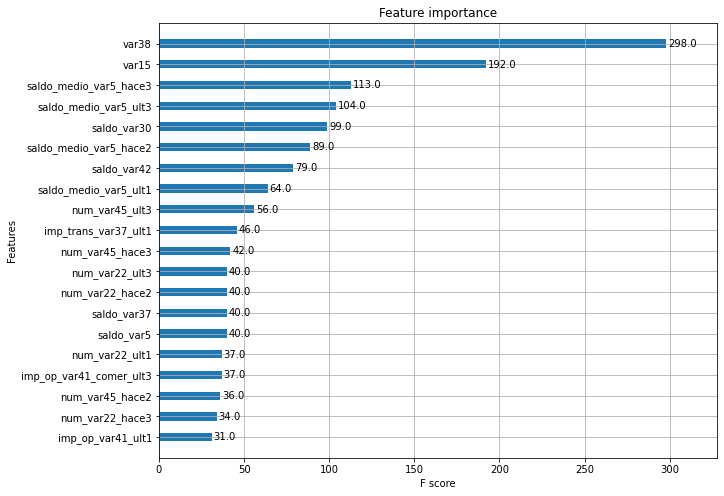

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

튜닝 전 - 0.8384

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgbm

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, callbacks=[lgbm.early_stopping(stopping_rounds=50)], eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.91059	training's binary_logloss: 0.112183	valid_1's auc: 0.831787	valid_1's binary_logloss: 0.13527
ROC AUC: 0.8384


In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']),
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(X_tr, y_tr, callbacks=[lgbm.early_stopping(stopping_rounds=30)], eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.88765	training's binary_logloss: 0.121808	valid_1's auc: 0.831519	valid_1's binary_logloss: 0.135868
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185738 seconds.
You can set `force_row_wise=true` 

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']),
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, callbacks=[lgbm.early_stopping(stopping_rounds=100)],
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.899119	training's binary_logloss: 0.11717	valid_1's auc: 0.833934	valid_1's binary_logloss: 0.13474
ROC AUC: 0.8412


튜닝 전 0.8384 -> 튜닝 후 0.8412로 ROC AUC 상승

# 4-10. 분류 실습_신용카드_사기검출

불균형한 레이블 값 분포 해결 위한
- 언더 샘플링: 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방법
- 오버 샘플링: 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터 확보
  - SMOTE: K 최근접 이웃으로 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 신규 증식 (imbalanced-learn)

### 데이터 일차 가공 및 모델 학습/예측/평가

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/CUAI/파이썬 머신러닝 완벽 가이드/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [61]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [63]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [64]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

로지스틱 회귀 - 재현율 0.5946, AUC 0.9593

In [66]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593


In [67]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

LGBM - 재현율 0.7568, AUC 0.9790
- boost_from_average=False: 레이블 값이 불균형한 경우

In [68]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

### 데이터 분포도 변환 후 모델 학습/예측/평가


- 선형 모델(ex. 로지스틱 회귀)은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호

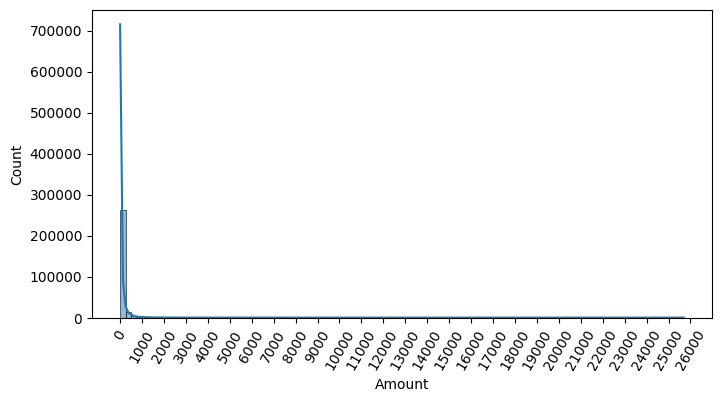

In [69]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

Amount를 정규 분포 형태로 변환

In [70]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [71]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

로그 변환 - 데이터의 분포도가 심하게 왜곡되어 있을 경우

In [73]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [74]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

### 이상치 데이터 제거 후 모델 학습/예측/평가

Q3 + 1.5 * IQR보다 크거나 Q1 + 1.5 * IQR보다 작으면 이상치로 규정

매우 많은 피처가 있을 경우 레이블과 가장 상관성이 높은 피처들 위주로 이상치 검출!

<Axes: >

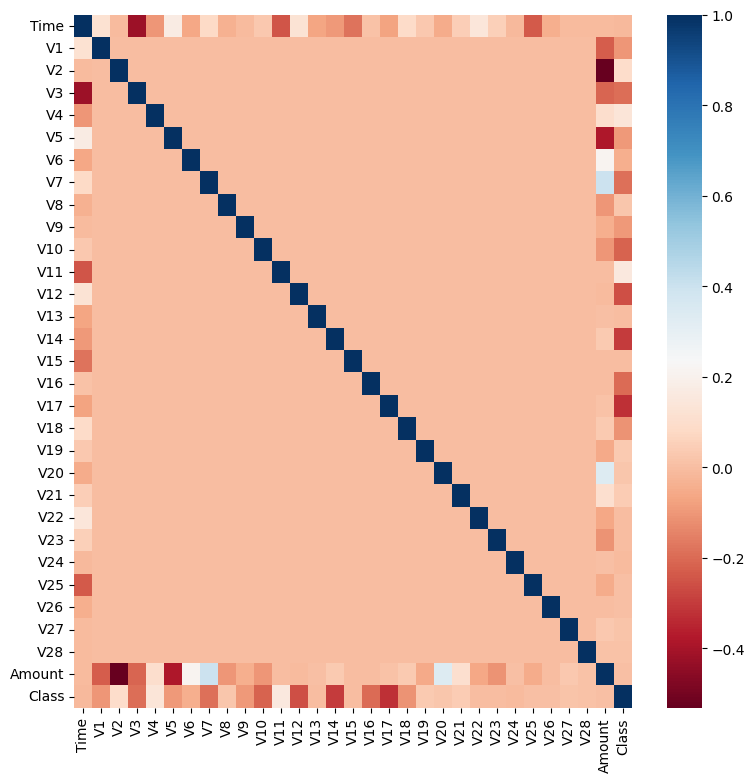

In [75]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

Class와 음의 상관관계가 가장 높은 V14, V17

In [76]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

V14 이상치 제거

In [77]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


이상치 제거 후 로지스틱 회귀, LGBM 재현율 크게 증가

In [78]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

- 반드시 학습 데이터 세트만 오버 샘플링해야 함
- 검증이나 테스트 데이터 세트를 오버 샘플링할 경우 결국 원본 데이터 세트가 아닌 데이터 세트에서 검증/테스트하기 때문에

In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


로지스틱 회귀 - 정밀도가 크게 하락

In [80]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없음

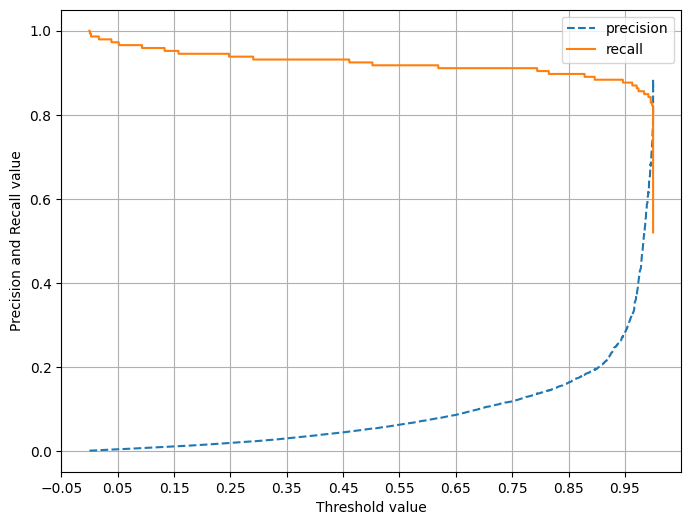

In [82]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

LGBM - SMOTE를 사용하면 재현율은 높아지나 정밀도가 낮아지는 게 일반적

In [83]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

# 4-11. 스태킹 앙상블

스태킹: 개별 알고리즘으로 예측한 데이터를 기반으로(메타 데이터) 별도의 ML 알고리즘으로 최종 학습 수행 -> 테스트 데이터로 최종 예측 수행

### 기본 스태킹 모델

In [103]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [104]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성.
lr_final = LogisticRegression(C=10)

In [86]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [87]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561 :


In [88]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [89]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


### CV 세트 기반의 스태킹

개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성 + 예측을 위한 테스트용 스태킹 데이터 생성

In [105]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [106]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [107]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [109]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
